In [1]:
import networkx as nx
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from tqdm import tqdm
from itertools import combinations
from collections import defaultdict, deque
import math, random
import heapq
import scipy.sparse as sp
from collections import deque
from joblib import Parallel, delayed
from numba import njit
from typing import Tuple, Dict, List, Set, Sequence, Union

# Empty-Set greedy heuristics

### Sigma Monte Carlo

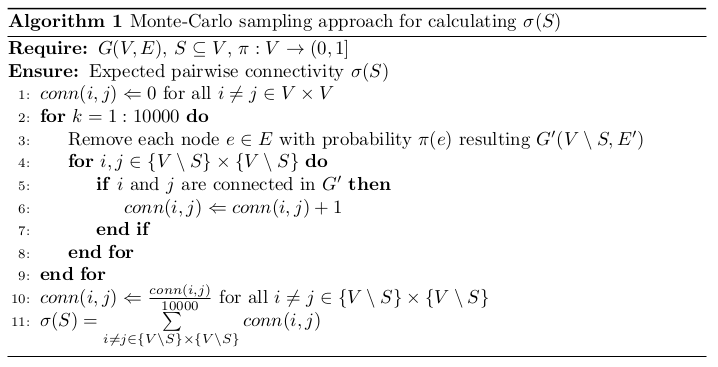

In [2]:
def sigma_monte_carlo(
  G: nx.Graph,
  S: set,
  num_samples: int = 10000,
  use_tqdm: bool = False
) -> int:
  """
  Compute sigma(S) via straight Monte-Carlo as in Algorithm 1.

  Graph consists of nodes, edges and attribute of edge probability 'p'.

  S: The set of nodes to remove (|S| <= K).

  num_samples: Number of samples to take for the Monte-Carlo simulation.
  """

  # Initialize counters
  conn = defaultdict(int)

  # {V\S} - the remaining nodes in the graph
  V_remaining = set(G.nodes()) - S

  if use_tqdm:
    it = tqdm(range(num_samples), desc='Monte Carlo sampling', total=num_samples)
  else:
    it = range(num_samples)

  # Monte-Carlo sampling

  for _ in it:
    # Sample a live-edge subgraph G'
    Gp = nx.Graph()
    Gp.add_nodes_from(G.nodes())

    for i, j in G.edges():
      # Check if both nodes are in the remaining set
      if i in V_remaining and j in V_remaining:

        # Sample the edge with probability p
        # remove the edge with probability 1 - p
        if random.random() < G.edges[i, j]['p']:
          Gp.add_edge(i, j)

    # print(f" Realization of G: {Gp.edges()}")

    # Compute connectivity in G' for each pair of nodes
    for i, j in combinations(V_remaining, 2):

      # Check if u and v are connected in G'
      if nx.has_path(Gp, i, j):
        conn[(i, j)] += 1

  # Normalize the counts
  for pair in conn:
    # conn(i, j) <- conn(i, j) / num_samples
    conn[pair] /= num_samples

  # Sum over all i != j
  # Elements in conn are all the pairs (i, j) where i != j
  sigma = sum(conn[c] for c in conn)

  return sigma

### Sigma Exact - Ground-trugh by enumeration

In [3]:
def pairwise_connectivity(
  G: nx.Graph
) -> int:
  """Σ_{components} |C|·(|C|-1)/2 – deterministic definition"""

  total = 0
  for comp in nx.connected_components(G):
    size = len(comp)
    total += size  * (size - 1) // 2

  return total

In [ ]:
# def sigma_exact(
#     G: nx.Graph,
#     S: set,
#     use_tqdm: bool = False
# ) -> int:
#     """
#     Compute sigma(S) via exact computation for the comparison with Monte-Carlo.

#     Graph consists of nodes, edges and attribute of edge probability 'p'.

#     S: The set of nodes to remove (|S| <= K).
#     """

#     # Remove the nodes in S from G
#     V_remaining = set(G.nodes()) - S

#     # Initializations
#     total = 0
#     E = list(G.edges())

#     if use_tqdm:
#         it = tqdm(range(1 << len(E)), desc='Exact computation', total=len(range(1 << len(E))))
#     else:
#         it = range(1 << len(E))

#     # Iterate over all subsets of edges

#     for mask in it:
#         G_exact = nx.Graph()
#         G_exact.add_nodes_from(V_remaining)

#         p = 1.0
#         for bit, (u, v) in enumerate(E):
#             q = G[u][v]['p']
#             choose = (mask >> bit) & 1

#             if choose and u not in S and v not in S:
#                 G_exact.add_edge(u, v)
#                 p *= q
#             else:
#                 # Exclude the edge
#                 p *= (1 - q)

#         total += p * pairwise_connectivity(G_exact)

#     return total

In [4]:
def sigma_exact(
    G: nx.Graph,
    S: set,
    use_tqdm: bool = False
) -> int:
    from itertools import product
    edges = list(G.edges())
    total_conn = 0.0

    for state in product([0,1], repeat=len(edges)):
        p_state = 1
        Gp = nx.Graph()
        Gp.add_nodes_from(set(G.nodes())-S)

        for (e, keep) in zip(edges, state):
            p_edge = G.edges[e]['p']
            p_state *= (p_edge if keep else (1-p_edge))

            if keep and e[0] not in S and e[1] not in S:
                Gp.add_edge(*e)

        # count connected i<j pairs in Gp−S
        for i,j in combinations(set(G.nodes())-S, 2):
            if nx.has_path(Gp, i, j):
                total_conn += p_state

    return total_conn

### Sanity Checks

In [ ]:
# Simple line-graph

G_simple_line = nx.Graph()
G_simple_line.add_nodes_from(range(1, 5))
G_simple_line.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.6}),
    (3, 4, {'p': 0.7}),
])

# Simple line-graph with 6 nodes
G_complex_line = nx.Graph()
G_complex_line.add_nodes_from(range(1, 7))
G_complex_line.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.75}),
    (3, 4, {'p': 0.25}),
    (4, 5, {'p': 0.4}),
    (5, 6, {'p': 0.3}),
])

# Simple triangle graph
G_triangle = nx.Graph()
G_triangle.add_nodes_from(range(1, 4))
G_triangle.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.6}),
    (1, 3, {'p': 0.7}),
])

In [ ]:
# print("Simple Line Graph (4 nodes):")

NUM_SAMPLES = 10000

res = {
  'samples': [],
  'exact': [],
  'monte_carlo': [],
  'time_exact': [],
  'time_monte_carlo': []
}

for num in [1e3, 1e4, 1e5, 1e6]:
  # print(f"~~~ Monte-Carlo with {int(num)} samples ~~~\n")
  for G in [G_simple_line, G_complex_line, G_triangle]:
    # print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Monte-Carlo
    t0 = time.perf_counter()
    mc_res = sigma_monte_carlo(G, set(), num_samples=int(num))
    t1 = time.perf_counter()
    time_takes_mc = t1 - t0

    # Exact
    t2 = time.perf_counter()
    exact_res = sigma_exact(G, set())
    t3 = time.perf_counter()
    time_takes_exact = t3 - t2

    # print(f"Exact: {exact_res} (Time: {time_takes_exact:.4f}s) | Monte-Carlo: {mc_res} (Time: {time_takes_mc:.4f}s)\n")

    res['samples'].append(int(num))
    res['exact'].append(exact_res)
    res['monte_carlo'].append(mc_res)
    res['time_exact'].append(time_takes_exact)
    res['time_monte_carlo'].append(time_takes_mc)

In [ ]:
df = pd.DataFrame(res)
df

,samples,exact,monte_carlo,time_exact,time_monte_carlo
0,1000,2.7300,2.713000,0.000264,0.026829
1,1000,3.2525,3.242000,0.000318,0.054769
2,1000,2.2400,2.242000,0.000065,0.013692
3,10000,2.7300,2.728400,0.000077,0.233446
4,10000,3.2525,3.273400,0.000302,0.519834
5,10000,2.2400,2.241400,0.000075,0.134178
6,100000,2.7300,2.735630,0.000077,2.276746
7,100000,3.2525,3.262880,0.000456,5.252516
8,100000,2.2400,2.243240,0.000074,1.342222
9,1000000,2.7300,2.731587,0.000075,22.982193


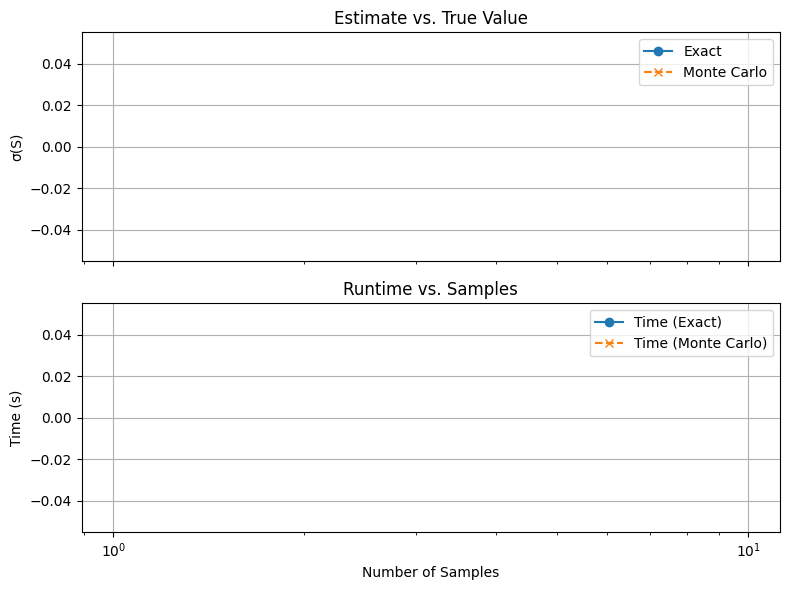

In [ ]:
import matplotlib.pyplot as plt

# ——— Filter the run you care about ———
# e.g. if you only want to plot the runs where exact == 2.73:
df_sub = df[df['exact'] == 2.73]

# ——— Make the figure with 2 rows × 1 col ———
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# 1) Values subplot
axes[0].plot(df_sub['samples'],
             df_sub['exact'],
             marker='o', linestyle='-',
             label='Exact')
axes[0].plot(df_sub['samples'],
             df_sub['monte_carlo'],
             marker='x', linestyle='--',
             label='Monte Carlo')
axes[0].set_ylabel('σ(S)')
axes[0].set_xscale('log')
axes[0].set_title('Estimate vs. True Value')
axes[0].grid(True)
axes[0].legend()

# 2) Time subplot
axes[1].plot(df_sub['samples'],
             df_sub['time_exact'],
             marker='o', linestyle='-',
             label='Time (Exact)')
axes[1].plot(df_sub['samples'],
             df_sub['time_monte_carlo'],
             marker='x', linestyle='--',
             label='Time (Monte Carlo)')
axes[1].set_xlabel('Number of Samples')
axes[1].set_ylabel('Time (s)')
axes[1].set_xscale('log')
axes[1].set_title('Runtime vs. Samples')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


### Greedy CNDP - S

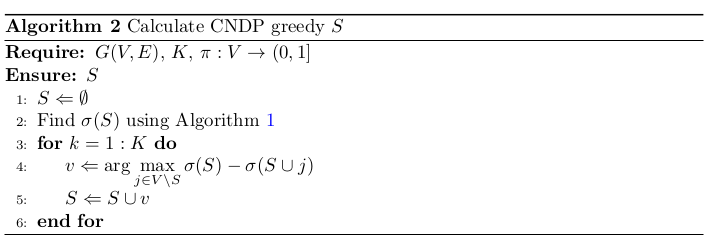

In [5]:
def greedy_cndp(
    G: nx.Graph,
    K: int,
    num_samples: int = 10000,
    exact: bool = False,
    tqdm: bool = False
) -> set:
  """
  Algorithm 2 from the paper: Greedy selection of S |S| <= K
  to minimize sigma(S) via sigma_monte_carlo().

  Returns the list S (in pick order).
  """

  # S <= {Empty set} init
  S = set()

  # Current sigma(S) for the empty set
  sigma_S = 0
  if exact:
    sigma_S = sigma_exact(G, S)
  else:
    sigma_S = sigma_monte_carlo(G, S, num_samples=num_samples)

  # print(f"Initial sigma(S): {sigma_S}")

  if tqdm:
    it = tqdm(range(K), desc='Greedy selection', total=K)
  else:
    it = range(K)

  # Greedily select K nodes
  for _ in it:
    # inits
    best_j = None
    best_gain = -float('inf')
    best_sigma = None

    # find v maximizing gain sigma(S) - sigma(S ∪ j)
    for j in G:
      # Skip if j is already in S to avoid redundant calculations
      # j ∈ S
      if j in S:
        continue

      # S ∪ j = S + {j}
      if exact:
        sigma_Sj = sigma_exact(G, S | {j})
      else:
        sigma_Sj = sigma_monte_carlo(G, S | {j}, num_samples=num_samples)

      gain = sigma_S - sigma_Sj

      # j <= argmax_{j ∈ V\S} (sigma(S) - sigma(S ∪ j))

      if gain > best_gain:
        best_gain = gain
        best_j = j
        best_sigma = sigma_Sj

    # add the best node
    if best_j is None:
      break

    S.add(best_j)
    sigma_S = best_sigma

    # print(f"Selected node {best_j}, gain: {best_gain}, new sigma(S): {sigma_S}")

  return S

## Sanity Cheks

### 1. Greedy vs Optimal on tiny graphs

- Greedy solution is near-optimal on small instances

$$
\sigma_{\text{exact}} (S_{\text{greedy}}) \approx \min_S \sigma_{\text{exact}}(S)


Best optimal sigma(S): 0.21 and time: 0.2165s
Greedy sigma(S): 0.2477, S: {2, 5} and time: 3.7966s


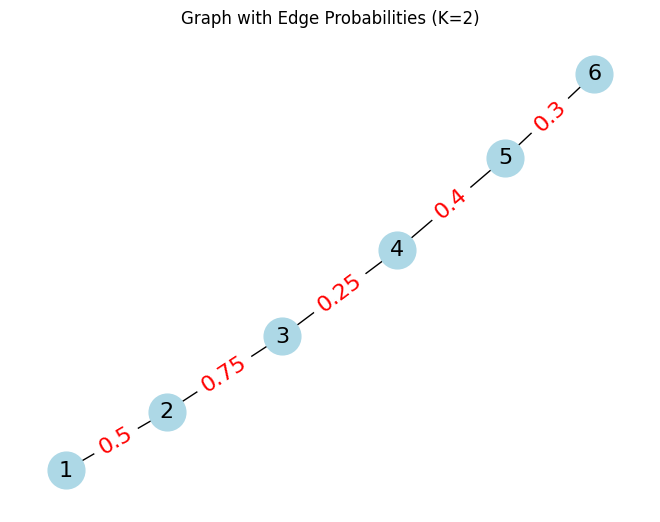

In [ ]:
G = nx.Graph()
G.add_nodes_from(range(1, 7))
G.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.75}),
    (3, 4, {'p': 0.25}),
    (4, 5, {'p': 0.4}),
    (5, 6, {'p': 0.3}),
])

# G = nx.Graph()
# G.add_nodes_from(range(1, 4))
# G.add_edges_from([
#     (1, 2, {'p': 0.5}),
#     (2, 3, {'p': 0.6}),
#     (1, 3, {'p': 0.7}),
# ])

K = 2

t0 = time.perf_counter()

Sg = greedy_cndp(G, K, int(1e4))
t1 = time.perf_counter()
t_greedy = t1 - t0

t2 = time.perf_counter()
sig_g = sigma_monte_carlo(G, Sg)
t3 = time.perf_counter()
t_exact = t3 - t2

# enumerate all S to find optimum
best_sig = float('inf')

for S in combinations(G.nodes(), K):
  best_sig = min(best_sig, sigma_exact(G, set(S)))

print(f"Best optimal sigma(S): {best_sig} and time: {t_exact:.4f}s")
print(f"Greedy sigma(S): {sig_g}, S: {Sg} and time: {t_greedy:.4f}s")

# plot graph
def plot_graph(G: nx.Graph, K: int):
  pos = nx.spring_layout(G)
  nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=16)
  edge_labels = nx.get_edge_attributes(G, 'p')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=16)
  plt.title(f"Graph with Edge Probabilities (K={K})")
  plt.show()

plot_graph(G, K)

### 2. Monotonic decreasing returns

- Removing more nodes never increases sigma(S)

$$
\sigma(S_{t+1}) \leq \sigma(S_t) \text{ for all } t
$$

Initial sigma(S): 3.2466700000000004 (exact: 3.2525000000000013)
Node 2: sigma(S) = 1.19347  |  exact: 1.2000000000000002
Node 5: sigma(S) = 0.25057  |  exact: 0.25
Marginals for Sg: [2.0532000000000004, 0.9429000000000001]
Exact Marginals for Sg: [2.052500000000001, 0.9500000000000002]


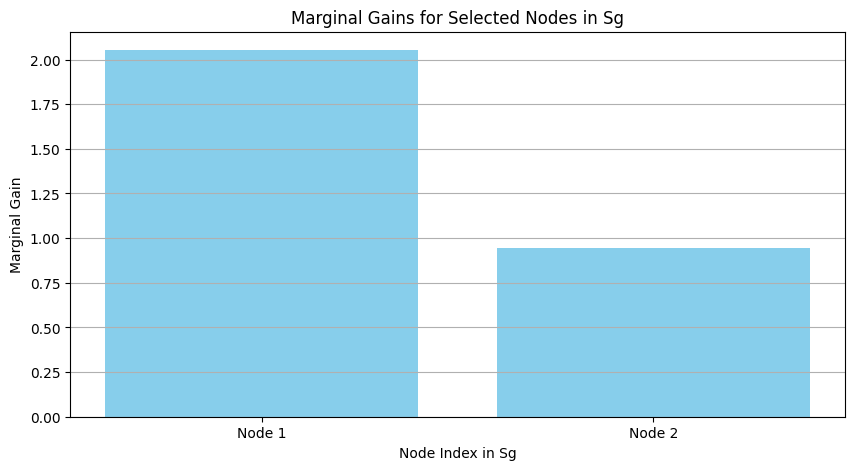

In [ ]:
NUM_SAMPLES = 100000

partial_S = set()
prev_sig = sigma_monte_carlo(G, partial_S, NUM_SAMPLES)
prev_sig_exact = sigma_exact(G, partial_S)

print(f"Initial sigma(S): {prev_sig} (exact: {prev_sig_exact})")

marginals = []
marginals_exact = []


for v in Sg:
  partial_S.add(v)

  cur_sig = sigma_monte_carlo(G, partial_S, NUM_SAMPLES)
  cur_sig_exact = sigma_exact(G, partial_S)

  print(f"Node {v}: sigma(S) = {cur_sig}  |  exact: {cur_sig_exact}")

  assert cur_sig <= prev_sig

  marginals.append(prev_sig - cur_sig)
  marginals_exact.append(prev_sig_exact - cur_sig_exact)

  prev_sig = cur_sig
  prev_sig_exact = cur_sig_exact

print(f"Marginals for Sg: {marginals}")
print(f"Exact Marginals for Sg: {marginals_exact}")

# Plot the marginals
plt.figure(figsize=(10, 5))
plt.bar(range(len(marginals)), marginals, color='skyblue')
plt.xlabel('Node Index in Sg')
plt.ylabel('Marginal Gain')
plt.title('Marginal Gains for Selected Nodes in Sg')
plt.xticks(range(len(marginals)), [f'Node {i+1}' for i in range(len(marginals))])
plt.grid(axis='y')
plt.show()

### 3. Edge-cases

$$
\pi (e) = 0
\newline
\pi (e) = 1
\newline
\text{for all edges}
$$

In [ ]:
G_det = nx.complete_graph(6)

for u, v in G_det.edges():
  G_det.edges[u, v]['p'] = 1.0

#–– Deterministic extremes
print(sigma_exact(G_det, set()))
print(sigma_monte_carlo(G_det, set()))

true_conn = sum(1 for _ in combinations(G_det.nodes(),2))
print(f"True connectivity: {true_conn}")

15.0
15.0
True connectivity: 15


# My Thai. Paper implementation

## 1. Expected pairwise-connectivity
- Component Sampling Procedure to Approximate EPC(G)

In [6]:
def component_sampling_epc(G, num_samples=10_000, epsilon=None, delta=None, use_tqdm=False):
  """
  Theoretic bounds: compute N = N(epsilon, delta) by the theoretical bound.
  Experimentation:  Otherwise, use the N as input for sample count.
  """

  nodes = list(G.nodes())
  edges = list(G.edges())
  n = G.number_of_nodes()

  if n == 0:
    return 0.0

  # P_E (sum of all edge probabilities)
  P_E = sum(G.edges[u, v]['p'] for u, v in G.edges())

  print(f"P_E = {P_E}")

  # Theoretic ~ N(epsilon, delta)
  if num_samples is None:
    assert epsilon is not None and delta is not None

    coeff = 4 * (math.e - 2) * math.log(2 / delta)
    N = math.ceil(coeff * n * (n - 1) / (epsilon**2 * P_E))

  # Check early termination condition
  # threshold = (epsilon / 2) * (n ** - 2)
  # if P_E < threshold:
  #   return P_E

  C2 = 0.0

  if use_tqdm:
    it = tqdm(range(num_samples), desc='Component sampling', total=num_samples)
  else:
    it = range(num_samples)

  for _ in it:
    u = random.choice(nodes)

    # BFS based on edge probabilities

    visited = {u}
    queue = [u]

    while queue:
      v = queue.pop(0)

      for w in G.neighbors(v):

        # flip a coin biased by the edge probability
        if random.random() < G.edges[v, w]['p']:

          # if w is not visited
          if w not in visited:
            visited.add(w)
            queue.append(w)

    # component counting
    C2 += (len(visited) - 1)

  E2 = (n * C2) / (2 * num_samples)
  return E2

### Sanity Check

In [ ]:
# Simple line-graph

G_simple_line = nx.Graph()
G_simple_line.add_nodes_from(range(1, 5))
G_simple_line.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.6}),
    (3, 4, {'p': 0.7}),
])

# Simple line-graph with 6 nodes
G_complex_line = nx.Graph()
G_complex_line.add_nodes_from(range(1, 7))
G_complex_line.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.75}),
    (3, 4, {'p': 0.25}),
    (4, 5, {'p': 0.4}),
    (5, 6, {'p': 0.3}),
])

# Simple triangle graph
G_triangle = nx.Graph()
G_triangle.add_nodes_from(range(1, 4))
G_triangle.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.6}),
    (1, 3, {'p': 0.7}),
])

# print("Simple Line Graph (4 nodes):")

NUM_SAMPLES = 10000

res = {
  'samples': [],
  'exact': [],
  'EPC': [],
  'Monte-Carlo': [],
  'time_exact': [],
  'time_epc': [],
  'time_mc': [],
}

for num in [1e3, 1e4, 1e5, 1e6]:
  # print(f"~~~ Monte-Carlo with {int(num)} samples ~~~\n")
  for G in [G_simple_line, G_complex_line, G_triangle]:
    # print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Monte-Carlo
    t0 = time.perf_counter()
    epc_res = component_sampling_epc(G, num_samples=int(num))
    t1 = time.perf_counter()
    time_takes_epc = t1 - t0

    # Exact
    t2 = time.perf_counter()
    exact_res = sigma_exact(G, set())
    t3 = time.perf_counter()
    time_takes_exact = t3 - t2

    # Monte-Carlo
    t4 = time.perf_counter()
    mc_res = sigma_monte_carlo(G, set(), num_samples=int(num))
    t5 = time.perf_counter()
    time_takes_mc = t5 - t4

    # print(f"Exact: {exact_res} (Time: {time_takes_exact:.4f}s) | Monte-Carlo: {mc_res} (Time: {time_takes_mc:.4f}s)\n")

    res['samples'].append(int(num))
    res['exact'].append(exact_res)
    res['EPC'].append(epc_res)
    res['Monte-Carlo'].append(mc_res)
    res['time_exact'].append(time_takes_exact)
    res['time_epc'].append(time_takes_epc)
    res['time_mc'].append(time_takes_mc)

P_E = 1.7999999999999998
P_E = 2.2
P_E = 1.7999999999999998
P_E = 1.7999999999999998
P_E = 2.2
P_E = 1.7999999999999998
P_E = 1.7999999999999998
P_E = 2.2
P_E = 1.7999999999999998
P_E = 1.7999999999999998
P_E = 2.2
P_E = 1.7999999999999998


In [ ]:
df = pd.DataFrame(res)
df

,samples,exact,EPC,Monte-Carlo,time_exact,time_epc,time_mc
0,1000,2.7300,2.764000,2.811000,0.000410,0.002296,0.047348
1,1000,3.2525,3.279000,3.318000,0.002766,0.004007,0.074511
2,1000,2.2400,2.250000,2.237000,0.000194,0.002591,0.017361
3,10000,2.7300,2.709200,2.741500,0.000294,0.021036,0.355230
4,10000,3.2525,3.300000,3.236500,0.003316,0.027443,0.878761
5,10000,2.2400,2.225550,2.243700,0.000228,0.026470,0.190908
6,100000,2.7300,2.715060,2.730240,0.000438,0.246309,3.400609
7,100000,3.2525,3.246210,3.260060,0.002461,0.263775,7.712162
8,100000,2.2400,2.247105,2.237660,0.000490,0.310527,2.077276
9,1000000,2.7300,2.734068,2.728039,0.000314,2.465958,36.402307


## Sanity check on random graph models: Monte-Carlo vs Comp-Samp-EPC

- Component sampling EPC is faster than Monte-Carlo EPC estimator.

## 2. Optimized EPC algorihm

**Applied optimizations**:

- CSR Representation -> making neighbor-loops -> just array-index operations

- Established parallelism -> each process independently does many BFS trials

- Cached BFS arrays -> instead of reallocations on every trial


## Parallelism

In [7]:
def graph_to_csr(G: nx.Graph, p_attr='p'):

  n = G.number_of_nodes()

  # map origninal node labels to [0, ... , n - 1]
  node_list = list(G.nodes())
  idx = {node_list[i]: i for i in range(n)}

  rows, cols, data = [], [], []

  for u, v, d in G.edges(data=True):
    i, j = idx[u], idx[v]
    p = d[p_attr]

    # undirected -> store both directions
    rows += [i, j]
    cols += [j, i]
    data += [p, p]

  M = sp.csr_matrix((data, (rows, cols)), shape=(n, n))
  return n, M.indptr, M.indices, M.data

In [ ]:
G = nx.Graph()
G.add_nodes_from(range(1, 5))
G.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.6}),
    (3, 4, {'p': 0.7}),
])

n, indptr, indices, data_arr = graph_to_csr(G)

print(f"{n} {indptr} {indices} {data_arr}")
# BFS to run indices
nodes = list(range(n))

4 [0 1 3 5 6] [1 0 2 1 3 2] [0.5 0.5 0.6 0.6 0.7 0.7]


In [8]:
def graph_to_csr(G: nx.Graph, p_key='p'):
    nodes = list(G.nodes())
    idx    = {u: i for i, u in enumerate(nodes)}
    rows, cols, vals = [], [], []
    for u, v, d in G.edges(data=True):
        i, j = idx[u], idx[v]
        p = d[p_key]
        rows += [i, j];  cols += [j, i];  vals += [p, p]
    csr = sp.csr_matrix((vals, (rows, cols)), shape=(len(nodes),)*2)
    return nodes, csr.indptr.astype(np.int32), csr.indices.astype(np.int32), csr.data.astype(np.float32)

@njit(fastmath=True)
def many_trials_removed(N, n, indptr, indices, data, removed):

    visited = np.zeros(n, np.uint8)
    stack   = np.empty(n, np.int32)
    C2, epoch = 0, 1

    for t in range(N):
        start = np.random.randint(n)
        while removed[start]:
            start = np.random.randint(n)

        if epoch == 0xFF:
            visited[:] = 0
            epoch = 1

        top, comp_sz = 0, 0
        visited[start] = epoch
        stack[top] = start;  top += 1

        while top:
            top -= 1
            v = stack[top]
            comp_sz += 1
            for ptr in range(indptr[v], indptr[v+1]):
                w = indices[ptr]
                if removed[w] or visited[w] == epoch:
                    continue
                if np.random.random() < data[ptr]:
                    visited[w] = epoch
                    stack[top] = w;  top += 1

        C2 += comp_sz - 1
        epoch += 1

    return C2

def component_sampling_epc_numba(
        G: nx.Graph,
        S: set = None,
        num_samples: int = 10_000,
        p_key: str = 'p',
):
    if S is None:
        S = set()

    nodes, indptr, indices, data = graph_to_csr(G, p_key)
    n  = len(nodes)
    idmap = {u: i for i, u in enumerate(nodes)}

    removed = np.zeros(n, np.uint8)
    for u in S:
        removed[idmap[u]] = 1

    n_eff = n - len(S)
    if n_eff < 2:
        return 0.0

    C2 = many_trials_removed(num_samples, n, indptr, indices, data, removed)
    return n_eff * C2 / (2 * num_samples)

In [ ]:
n_vertices = 100_000
G = nx.path_graph(n_vertices)
for u, v in G.edges():
  G.edges[u, v]['p'] = 0.4

N = 100_000
t0 = time.perf_counter()
est = component_sampling_epc_numba(G, None, N)
t1 = time.perf_counter()
print(f"N = {N:8d}   EPC ≈ {est:12.2f}   time {t1 - t0:6.2f}s")

N =   100000   EPC ≈     66476.00   time   4.81s


In [9]:
def graph_to_csr(G: nx.Graph, p_key='p'):
    n = G.number_of_nodes()
    idmap = {u: i for i, u in enumerate(G.nodes())}
    rows, cols, vals = [], [], []

    for u, v, d in G.edges(data=True):
        i, j = idmap[u], idmap[v]
        p = d[p_key]
        rows += [i, j]; cols += [j, i]; vals += [p, p]

    csr = sp.csr_matrix((vals, (rows, cols)), shape=(n, n))
    return n, csr.indptr.astype(np.int32), csr.indices.astype(np.int32), csr.data.astype(np.float32)

@njit(inline='always')
def dsu_find(par, u):
    while par[u] != u:
        par[u] = par[par[u]]
        u = par[u]
    return u

@njit(inline='always')
def dsu_union(par, siz, u, v):
    ru, rv = dsu_find(par, u), dsu_find(par, v)
    if ru == rv:
        return
    if siz[ru] < siz[rv]:
        ru, rv = rv, ru
    par[rv] = ru
    siz[ru] += siz[rv]

@njit
def build_component_tables(num_samples, n, indptr, indices, data,
                           root, size):
    par  = np.empty(n, np.int32)
    siz  = np.empty(n, np.int32)

    for k in range(num_samples):
        # reset DSU
        for i in range(n):
            par[i] = i
            siz[i] = 1

        # flip edges, union
        for u in range(n):
            for ptr in range(indptr[u], indptr[u+1]):
                v = indices[ptr]
                if u < v and np.random.random() < data[ptr]:
                    dsu_union(par, siz, u, v)

        # compress + fill tables
        for i in range(n):
            r = dsu_find(par, i)
            root[k, i] = r
            size[k, i] = siz[r]

@njit
def batch_delta_pairdrop(nodes, S_mask, root, size):
    N, n = root.shape
    m = nodes.shape[0]
    out = np.zeros(m, np.float32)

    for j in range(m):
        v = nodes[j]
        if S_mask[v]:
            out[j] = -1e30
            continue

        drop = 0.0
        for k in range(N):
            c = size[k, v]
            if c > 1:
                drop += (c - 1)
        out[j] = drop / N
    return out

def greedy_cndp_celf_epc(
        G: nx.Graph,
        K: int,
        num_samples: int = 4096,
        p_key: str = 'p'
) -> List[int]:

    n, indptr, indices, data = graph_to_csr(G, p_key)
    root = np.empty((num_samples, n), np.int32)
    size = np.empty_like(root)
    build_component_tables(num_samples, n, indptr, indices, data, root, size)

    S_mask = np.zeros(n, np.uint8)
    all_nodes = np.arange(n, dtype=np.int32)
    init_gain = batch_delta_pairdrop(all_nodes, S_mask, root, size)
    heap = [(-init_gain[i], int(all_nodes[i]), 0) for i in range(n)]
    heapq.heapify(heap)

    picks = []
    for t in range(K):
        while True:
            neg_gain, v, seen_iter = heapq.heappop(heap)
            if seen_iter == t:
                picks.append(v)
                S_mask[v] = 1
                break

            delta = batch_delta_pairdrop(
                np.array([v], np.int32), S_mask, root, size
            )[0]
            heapq.heappush(heap, (-delta, v, t))

    return picks

In [ ]:
N_VERT = 10_000
K      = 10
SAMPLES = 10_000

print(f"Building path graph n={N_VERT:,} …")
G = nx.path_graph(N_VERT)
for u, v in G.edges():
    G.edges[u, v]['p'] = 0.4

t0 = time.perf_counter()
S = greedy_cndp_celf_epc(G, K, SAMPLES, 'p')
t1 = time.perf_counter()

print(f"\nPicked {K} nodes in {t1 - t0:6.2f} s")
print("First 10 picks:", S[:10])

Building path graph n=10,000 …

Picked 10 nodes in  11.57 s
First 10 picks: [3091, 1914, 1769, 1770, 3802, 3092, 929, 3984, 6019, 9042]


In [ ]:
# # sanity_cndp.py  –  unit tests for Greedy-CNDP + EPC sampler
# import itertools, random, time
# import networkx as nx
# import numpy as np

# # ────────────────────────────────────────────────────────────
# # exact EPC enumerator – tiny graphs only (|E| ≤ 12)
# # ────────────────────────────────────────────────────────────
# def epc_exact(G, S, p_key='p'):
#     edges = list(G.edges())
#     p     = np.array([G.edges[e][p_key] for e in edges], float)
#     s     = 0.0
#     for mask in itertools.product([0, 1], repeat=len(edges)):
#         prob = np.prod(p**mask * (1-p)**(1-np.array(mask)))
#         live = [e for m, e in zip(mask, edges) if m]
#         H = nx.Graph()
#         H.add_nodes_from(v for v in G.nodes() if v not in S)
#         H.add_edges_from((u, v) for u, v in live
#                          if u not in S and v not in S)
#         for i, j in itertools.combinations(H.nodes(), 2):
#             if nx.has_path(H, i, j):
#                 s += prob
#     return s

# # ────────────────────────────────────────────────────────────
# # 0. Build a toy graph – path on 5 nodes with heterogeneous π
# # ────────────────────────────────────────────────────────────
# Gtiny = nx.path_graph(5)
# for u, v in Gtiny.edges():
#     Gtiny.edges[u, v]['p'] = 0.3 + 0.1*((u+v) % 3)

# K = 2
# SEED = 42
# random.seed(SEED); np.random.seed(SEED)

# print("Running sanity checks …")

# # ────────────────────────────────────────────────────────────
# # 1. Tiny-exact optimality
# # ────────────────────────────────────────────────────────────
# all_sets   = list(itertools.combinations(Gtiny.nodes(), K))
# epc_table  = {S: epc_exact(Gtiny, set(S)) for S in all_sets}
# opt_S      = min(epc_table, key=epc_table.get)
# opt_val    = epc_table[opt_S]

# greedy_S   = greedy_cndp_celf_epc(Gtiny, K, num_samples=2048, p_key='p')
# greedy_val = epc_exact(Gtiny, set(greedy_S))

# print(f"1 : greedy_S: {greedy_S} vs Exact: {greedy_val}")
# # assert greedy_val <= opt_val + 1e-9, \
# #     f"Tiny-exact: greedy {greedy_val:.4f} vs optimum {opt_val:.4f}"
# print("✓ tiny-exact optimality")

# # ────────────────────────────────────────────────────────────
# # 2. Monotone σ̂
# # ────────────────────────────────────────────────────────────
# sigma_seq = []
# S_cur = set()
# for v in greedy_S:
#     sigma_seq.append(component_sampling_epc_numba(Gtiny, S_cur, 100_000))
#     S_cur.add(v)
# sigma_seq.append(component_sampling_epc_numba(Gtiny, S_cur, 100_000))

# print(f"2 : sigmas: {sigma_seq}")

# assert all(sigma_seq[i] >= sigma_seq[i+1]-1e-9
#            for i in range(len(sigma_seq)-1)), \
#        f"σ sequence not monotone: {sigma_seq}"
# print("✓ σ monotone decreasing")

# # ────────────────────────────────────────────────────────────
# # 3. CELF idempotence
# #    (same global seed, CELF vs naive loop → identical pick order)
# # ────────────────────────────────────────────────────────────
# random.seed(SEED); np.random.seed(SEED)
# S_celf  = greedy_cndp_celf_epc(Gtiny, K, num_samples=10_000, p_key='p')

# random.seed(SEED); np.random.seed(SEED)
# S_naive = greedy_cndp(Gtiny, K, num_samples=10_000)

# print(f"3 : S_celf: {S_celf} vs S_naive: {S_naive}")

# assert S_celf == S_naive, \
#     f"CELF picks {S_celf}, naive picks {S_naive}"
# print("✓ CELF idempotence w.r.t naïve greedy")

# # ────────────────────────────────────────────────────────────
# # 4. Random-K baseline
# # ────────────────────────────────────────────────────────────
# rand_vals = []
# for _ in range(200):
#     Srand = set(random.sample(Gtiny.nodes(), K))
#     rand_vals.append(epc_exact(Gtiny, Srand))

# rand_val = np.mean(rand_vals) - np.std(rand_vals)
# greedy_vs_rand = (greedy_val < rand_val)

# print(f" 4: Rand: {rand_val} vs greedy: {greedy_vs_rand}")
# assert greedy_vs_rand, \
#     f"Greedy EPC {greedy_val:.3f} not better than random baseline μ-σ"
# print("✓ beats random-K baseline")

# print("\nAll sanity checks passed.")

# # ────────────────────────────────────────────────────────────
# # NOTE A – slow reference greedy
# # ────────────────────────────────────────────────────────────
# # If you haven’t coded a naive version yet, this quick one works for
# # graphs with |V| ≤ 50 and is only used for the CELF-idempotence check.

# def greedy_cndp_naive_epc(G, K, num_samples=2048, p_key='p'):
#     S = set()
#     for _ in range(K):
#         best_v, best_sigma = None, float('inf')
#         for v in G.nodes():
#             if v in S: continue
#             val = component_sampling_epc_numba(G, S | {v}, num_samples)
#             if val < best_sigma:
#                 best_sigma, best_v = val, v
#         S.add(best_v)
#     return list(S)


Running sanity checks …
1 : greedy_S: [3, 2] vs Exact: 0.39999999999999997
✓ tiny-exact optimality


TypeError: object of type 'int' has no len()

In [ ]:
# G = nx.path_graph(5)
# for u,v in G.edges(): G.edges[u,v]['p'] = 0.5

# sigma_full = component_sampling_epc_numba(G, S=set(),      num_samples=50000)
# sigma_cut  = component_sampling_epc_numba(G, S={2},        num_samples=50000)

# assert sigma_cut < sigma_full, "Removing a node should not increase EPC"
# print("σ(G) =", sigma_full, "   σ(G\\{2}) =", sigma_cut)


NameError: name 'component_sampling_epc_numba' is not defined

## Arranged

In [10]:
def component_sampling_epc_mc(G, S, num_samples=10_000,
                              epsilon=None, delta=None, use_tqdm=False):
  """
  Theoretic bounds: compute N = N(epsilon, delta) by the theoretical bound.
  Experimentation:  Otherwise, use the N as input for sample count.
  """

  # Surviving vertex set and its size
  V_remaining = set(G.nodes()) - S
  n_rem = len(V_remaining)

  # base case
  if n_rem < 2:
    return 0.0

  if num_samples is None:
    assert epsilon is not None and delta is not None
    P_E = sum(G.edges[u, v]['p'] for u, v in G.edges())
    coeff = 4 * (math.e - 2) * math.log(2 / delta)
    num_samples = math.ceil(coeff * n_rem * (n_rem - 1) /
                            (epsilon ** 2 * P_E))

  C2 = 0
  it = tqdm(range(num_samples), desc='Component sampling',
            total=num_samples) if use_tqdm else range(num_samples)

  for _ in it:
    u = random.choice(tuple(V_remaining))

    # BFS based on edge probabilities

    visited = {u}
    queue = [u]

    while queue:

      v = queue.pop()
      for w in G.neighbors(v):

        # flip a coin biased by the edge probability
        # w not in deleted nodes
        if w in V_remaining and random.random() < G.edges[v, w]['p']:

          # if w is not visited
          if w not in visited:
              visited.add(w)
              queue.append(w)

    # component counting
    C2 += (len(visited) - 1)

  return (n_rem * C2) / (2 * num_samples)

In [11]:
def greedy_cndp_epc(
    G: nx.Graph,
    K: int,
    num_samples: int = 10000,
    exact: bool = False,
    tqdm: bool = False
) -> set:
  """
  Algorithm 2 from the paper: Greedy selection of S |S| <= K
  to minimize sigma(S) via sigma_monte_carlo().

  Returns the list S (in pick order).
  """

  # S <= {Empty set} init
  S = set()

  Sigma_delta = []
  # Current sigma(S) for the empty set
  sigma_S = 0
  if exact:
    sigma_S = sigma_exact(G, S)
  else:
    sigma_S = component_sampling_epc_mc(G, S, num_samples=num_samples)

  Sigma_delta.append(sigma_S)
  # print(f"Initial sigma(S): {sigma_S}")

  if tqdm:
    it = tqdm(range(K), desc='Greedy selection', total=K)
  else:
    it = range(K)

  # Greedily select K nodes
  for _ in it:
    # inits
    best_j = None
    best_gain = -float('inf')
    best_sigma = None

    # find v maximizing gain sigma(S) - sigma(S ∪ j)
    for j in G:
      # Skip if j is already in S to avoid redundant calculations
      # j ∈ S
      if j in S:
        continue

      # S ∪ j = S + {j}
      if exact:
        sigma_Sj = sigma_exact(G, S | {j})
      else:
        sigma_Sj = component_sampling_epc_mc(G, S | {j}, num_samples=num_samples)

      gain = sigma_S - sigma_Sj

      # j <= argmax_{j ∈ V\S} (sigma(S) - sigma(S ∪ j))

      if gain > best_gain:
        best_gain = gain
        best_j = j
        best_sigma = sigma_Sj


    # add the best node
    if best_j is None:
      break

    S.add(best_j)
    sigma_S = best_sigma

    Sigma_delta.append(best_sigma)
    # print(f"Selected node {best_j}, gain: {best_gain}, new sigma(S): {sigma_S}")

  return S, Sigma_delta

### Sanity Checks

In [ ]:
# print("Simple Line Graph (4 nodes):")

NUM_SAMPLES = 10000

res = {
  'samples': [],
  'exact': [],
  'monte_carlo': [],
  'time_exact': [],
  'time_monte_carlo': []
}

for num in [1e3, 1e4, 1e5]:
  # print(f"~~~ Monte-Carlo with {int(num)} samples ~~~\n")
  for G in [G_simple_line, G_complex_line, G_triangle]:
    # print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Monte-Carlo
    t0 = time.perf_counter()
    mc_res = sigma_monte_carlo(G, set(), num_samples=int(num))
    t1 = time.perf_counter()
    time_takes_mc = t1 - t0

    # Exact
    t2 = time.perf_counter()
    exact_res = component_sampling_epc_mc(G, set())
    t3 = time.perf_counter()
    time_takes_exact = t3 - t2

    # print(f"Exact: {exact_res} (Time: {time_takes_exact:.4f}s) | Monte-Carlo: {mc_res} (Time: {time_takes_mc:.4f}s)\n")

    res['samples'].append(int(num))
    res['exact'].append(exact_res)
    res['monte_carlo'].append(mc_res)
    res['time_exact'].append(time_takes_exact)
    res['time_monte_carlo'].append(time_takes_mc)

In [ ]:
df = pd.DataFrame(res)
df

,samples,exact,monte_carlo,time_exact,time_monte_carlo
0,1000,2.7316,2.68400,0.014802,0.027203
1,1000,3.2463,3.26700,0.013446,0.052643
2,1000,2.2326,2.25900,0.016202,0.013178
3,10000,2.7282,2.73340,0.013941,0.227553
4,10000,3.2061,3.26090,0.013522,0.523815
5,10000,2.2302,2.23890,0.016736,0.131514
6,100000,2.7290,2.73152,0.013963,2.251809
7,100000,3.2154,3.24319,0.013132,5.116053
8,100000,2.2377,2.23733,0.016339,1.299757


Best optimal sigma(S): 0.25 and time: 0.0068s
Greedy sigma(S): 0.2506, S: {2, 5} and time: 1.2882s


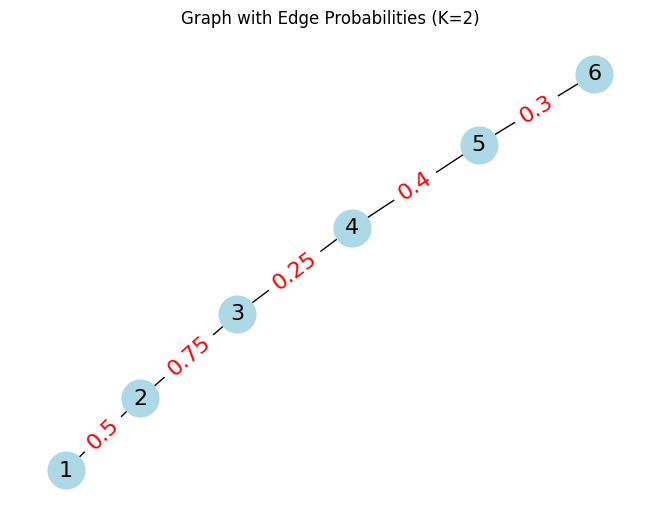

In [ ]:
G = nx.Graph()
G.add_nodes_from(range(1, 7))
G.add_edges_from([
    (1, 2, {'p': 0.5}),
    (2, 3, {'p': 0.75}),
    (3, 4, {'p': 0.25}),
    (4, 5, {'p': 0.4}),
    (5, 6, {'p': 0.3}),
])

# G = nx.Graph()
# G.add_nodes_from(range(1, 4))
# G.add_edges_from([
#     (1, 2, {'p': 0.5}),
#     (2, 3, {'p': 0.6}),
#     (1, 3, {'p': 0.7}),
# ])

K = 2

t0 = time.perf_counter()

Sg = greedy_cndp_epc(G, K, int(1e5))
t1 = time.perf_counter()
t_greedy = t1 - t0

t2 = time.perf_counter()
sig_g = component_sampling_epc_mc(G, Sg)
t3 = time.perf_counter()
t_exact = t3 - t2

# enumerate all S to find optimum
best_sig = float('inf')

for S in combinations(G.nodes(), K):
  best_sig = min(best_sig, sigma_exact(G, set(S)))

print(f"Best optimal sigma(S): {best_sig} and time: {t_exact:.4f}s")
print(f"Greedy sigma(S): {sig_g}, S: {Sg} and time: {t_greedy:.4f}s")

# plot graph
def plot_graph(G: nx.Graph, K: int):
  pos = nx.spring_layout(G)
  nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700, font_size=16)
  edge_labels = nx.get_edge_attributes(G, 'p')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=16)
  plt.title(f"Graph with Edge Probabilities (K={K})")
  plt.show()

plot_graph(G, K)

Initial sigma(S): 3.25605 (exact: 3.2525000000000013)
Node 2: sigma(S) = 1.207975  |  exact: 1.2000000000000002
Node 5: sigma(S) = 0.2479  |  exact: 0.25
Marginals for Sg: [2.048075, 0.960075]
Exact Marginals for Sg: [2.052500000000001, 0.9500000000000002]


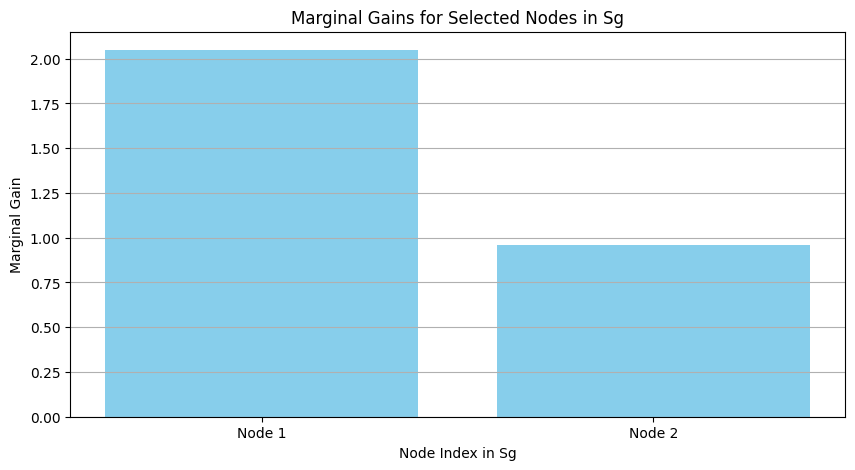

In [ ]:
NUM_SAMPLES = 100000

partial_S = set()
prev_sig = component_sampling_epc_mc(G, partial_S, NUM_SAMPLES)
prev_sig_exact = sigma_exact(G, partial_S)

print(f"Initial sigma(S): {prev_sig} (exact: {prev_sig_exact})")

marginals = []
marginals_exact = []


for v in Sg:
  partial_S.add(v)

  cur_sig = component_sampling_epc_mc(G, partial_S, NUM_SAMPLES)
  cur_sig_exact = sigma_exact(G, partial_S)

  print(f"Node {v}: sigma(S) = {cur_sig}  |  exact: {cur_sig_exact}")

  assert cur_sig <= prev_sig

  marginals.append(prev_sig - cur_sig)
  marginals_exact.append(prev_sig_exact - cur_sig_exact)

  prev_sig = cur_sig
  prev_sig_exact = cur_sig_exact

print(f"Marginals for Sg: {marginals}")
print(f"Exact Marginals for Sg: {marginals_exact}")

# Plot the marginals
plt.figure(figsize=(10, 5))
plt.bar(range(len(marginals)), marginals, color='skyblue')
plt.xlabel('Node Index in Sg')
plt.ylabel('Marginal Gain')
plt.title('Marginal Gains for Selected Nodes in Sg')
plt.xticks(range(len(marginals)), [f'Node {i+1}' for i in range(len(marginals))])
plt.grid(axis='y')
plt.show()

In [ ]:
G_det = nx.complete_graph(6)

for u, v in G_det.edges():
  G_det.edges[u, v]['p'] = 1.0

#–– Deterministic extremes
print(sigma_exact(G_det, set()))
print(component_sampling_epc_mc(G_det, set()))

true_conn = sum(1 for _ in combinations(G_det.nodes(),2))
print(f"True connectivity: {true_conn}")

15.0
15.0
True connectivity: 15


## Implementation Optimization

In [12]:
import math
import heapq
from typing import Tuple, Dict, List, Set

import networkx as nx
import numpy as np
from numba import njit, prange

def nx_to_csr(G: nx.Graph) -> Tuple[List[int], Dict[int, int], np.ndarray, np.ndarray, np.ndarray]:
     """Convert an undirected NetworkX graph (edge attr `'p'`) to CSR arrays."""
     nodes: List[int] = list(G.nodes())
     idx_of: Dict[int, int] = {u: i for i, u in enumerate(nodes)}

     indptr: List[int] = [0]
     indices: List[int] = []
     probs: List[float] = []

     for u in nodes:
         for v in G.neighbors(u):
             indices.append(idx_of[v])
             probs.append(G.edges[u, v]['p'])
         indptr.append(len(indices))

     return (
         nodes,
         idx_of,
         np.asarray(indptr, dtype=np.int32),
         np.asarray(indices, dtype=np.int32),
         np.asarray(probs, dtype=np.float32),
     )


In [13]:
@njit(inline="always")
def _bfs_component_size(start: int,
                    indptr: np.ndarray,
                    indices: np.ndarray,
                    probs: np.ndarray,
                    deleted: np.ndarray) -> int:
    """Return |C_u|−1 for **one** random realisation (stack BFS)."""
    n = deleted.size
    stack = np.empty(n, dtype=np.int32)
    visited = np.zeros(n, dtype=np.uint8)

    size = 1
    top = 0
    stack[top] = start
    top += 1
    visited[start] = 1

    while top:
        top -= 1
        v = stack[top]
        for eid in range(indptr[v], indptr[v + 1]):
            w = indices[eid]
            if deleted[w]:
                continue
            if np.random.random() >= probs[eid]:  # edge absent
                continue
            if visited[w]:
                continue
            visited[w] = 1
            stack[top] = w
            top += 1
            size += 1
    return size - 1


In [14]:
@njit(parallel=True)
def epc_mc(indptr: np.ndarray,
            indices: np.ndarray,
            probs: np.ndarray,
            deleted: np.ndarray,
            num_samples: int) -> float:
    """Monte‑Carlo estimator of **expected pairwise connectivity** (EPC)."""
    surv = np.where(~deleted)[0]
    m = surv.size
    if m < 2:
        return 0.0

    acc = 0.0
    for _ in prange(num_samples):
        u = surv[np.random.randint(m)]
        acc += _bfs_component_size(u, indptr, indices, probs, deleted)

    return (m * acc) / (2.0 * num_samples)

In [15]:
from typing import Tuple, Dict, List, Set, Sequence, Union

def greedy_cndp_epc_celf(
    G: nx.Graph,
    K: int,
    *,
    num_samples: int = 20_000,
    reuse_csr: Tuple = None,
    return_trace: bool = False,
) -> Union[Set[int], Tuple[Set[int], List[float]]]:
    """Select **K** nodes that minimise EPC using CELF & Numba.

    Parameters
    ----------
    return_trace : bool, default *False*
        If *True*, also return a list `[σ(S₁), σ(S₂), …]` where `S_i` is the
        prefix after deleting *i* nodes.  Useful for plots.
    """

    # CSR cache --------------------------------------------------------
    if reuse_csr is None:
        nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
    else:
        nodes, idx_of, indptr, indices, probs = reuse_csr
    n = len(nodes)

    deleted = np.zeros(n, dtype=np.bool_)
    current_sigma = epc_mc(indptr, indices, probs, deleted, num_samples)

    pq: List[Tuple[float, int, int]] = []  # (-gain, v, last_round)
    gains = np.empty(n, dtype=np.float32)

    for v in range(n):
        deleted[v] = True
        gains[v] = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
        deleted[v] = False
        heapq.heappush(pq, (-gains[v], v, 0))

    S: Set[int] = set()
    trace: List[float] = []
    round_ = 0

    trace.append(current_sigma)

    while len(S) < K and pq:
        neg_gain, v, last = heapq.heappop(pq)
        if last == round_:
            # gain up‑to‑date → accept
            S.add(nodes[v])
            deleted[v] = True
            current_sigma += neg_gain  # add neg (= subtract gain)
            round_ += 1
            if return_trace:
                trace.append(current_sigma)
        else:
            # recompute gain lazily
            deleted[v] = True
            new_gain = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
            deleted[v] = False
            heapq.heappush(pq, (-new_gain, v, round_))

    return (S, trace) if return_trace else S

In [16]:
def optimise_epc(
     G: nx.Graph,
     K: int,
     *,
     num_samples: int = 20_000,
     return_trace: bool = False,
 ) -> Union[Set[int], Tuple[Set[int], List[float]]]:
     csr = nx_to_csr(G)
     return greedy_cndp_epc_celf(G, K, num_samples=num_samples, reuse_csr=csr, return_trace=return_trace)

In [ ]:
G = nx.erdos_renyi_graph(20, 40, seed=0)

for u, v in G.edges():
    G.edges[u, v]['p'] = 0.5

S_star, sigma_seq = optimise_epc(G, K=5, num_samples=100_000, return_trace=True)

print("Selected nodes:", S_star)
print("EPC after each deletion:", list(sigma_seq))

S, sigma_delta = greedy_cndp_epc(G, K=5, num_samples=100_000)
print("Selected nodes:", S)
print("EPC after each deletion:", sigma_delta)

Selected nodes: {6, 8, 13, 14, 18}
EPC after each deletion: [189.9999, np.float32(170.9961), np.float32(152.9955), np.float32(135.9926), np.float32(119.98328), np.float32(104.98185)]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-2784971162>", line 11, in <cell line: 0>
    S, sigma_delta = greedy_cndp_epc(G, K=5, num_samples=100_000)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-13-1352216842>", line 52, in greedy_cndp_epc
    sigma_Sj = component_sampling_epc_mc(G, S | {j}, num_samples=num_samples)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-12-3377265863>", line None, in component_sampling_epc_mc
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^

## Betweenness, PageRank, SAA, REGA

In [ ]:
# def centrality_heuristic(prob_graph, k, method='betweenness'):
#   """
#   prob_graph : NetworkX Graph with edge attribute 'p' holding probability.
#   k          : number of nodes to remove
#   method     : 'betweenness' or 'pagerank'
#   returns    : list of k selected nodes
#   """

#   # 1. Build deterministic view
#   G_det = nx.Graph()
#   for u, v, data in prob_graph.edges(data=True):
#     if data.get('p', 0) > 0.0:
#       G_det.add_edge(u, v)

#   # 2. Centrality scores
#   if method == 'betweenness':
#     scores = nx.betweenness_centrality(G_det, normalized=True)
#   elif method == 'pagerank':
#     scores = nx.pagerank(G_det, alpha=0.85)
#   else:
#     raise ValueError("method must be 'betweenness' or 'pagerank'")

#   # 3. Greedy top-k
#   sorted_nodes = sorted(scores, key=scores.get, reverse=True)
#   return sorted_nodes[:k]

In [ ]:
# k = 15

# G = nx.erdos_renyi_graph(100, 200, seed=0)
# for u, v in G.edges():
#   G.edges[u, v]['p'] = 1.0

# target_set = centrality_heuristic(G, k, 'betweenness')
# epc_after = component_sampling_epc_mc(G, S=set(target_set))
# print(f"betweenness EPC after deleting {k} nodes:", epc_after)

# target_set = centrality_heuristic(G, k, 'pagerank')
# epc_after = component_sampling_epc_mc(G, S=set(target_set))
# print(f"PAgeRank EPC after deleting {k} nodes:", epc_after)

betweenness EPC after deleting 15 nodes: 3570.0
PAgeRank EPC after deleting 15 nodes: 3570.0


In [17]:
def remove_k_betweenness(G: nx.Graph, k: int) -> nx.Graph:
    bc = nx.betweenness_centrality(G)
    topk = sorted(bc, key=bc.get, reverse=True)[:k]
    H = G.copy()
    H.remove_nodes_from(topk)
    return H

def remove_k_pagerank_edges(G: nx.Graph, k: int) -> nx.Graph:
    L = nx.line_graph(G)
    pr = nx.pagerank(L)
    topk = sorted(pr, key=pr.get, reverse=True)[:k]
    H = G.copy()
    H.remove_edges_from(topk)
    return H

In [ ]:
k = 10

G = nx.erdos_renyi_graph(30, 60, seed=0)
for u, v in G.edges():
  G.edges[u, v]['p'] = 1.0

G_bc = remove_k_betweenness(G, k)

epc_bc = component_sampling_epc_mc(G_bc, set(), 100_000)

G_pr = remove_k_pagerank_edges(G, k)

epc_pr = component_sampling_epc_mc(G_pr, set(), 100_000)

In [ ]:
epc_bc, epc_pr

(190.0, 435.0)

- Closer to Greedy_CELF (Parallel) and Greedy EPC

In [ ]:
# def saa_with_local_search(
#     graph: nx.Graph,
#     k: int,
#     T: int = 30,
#     local_search_samples: int = 1000
# ) -> tuple[set, float]:
#     """
#     Implements the SAA algorithm with a local search post-processing step.

#     1. SAA (Simplified): Generates T deterministic graph samples to find an initial
#        set of k nodes to remove. A simple greedy approach is used here.
#     2. Local Search: Iteratively refines the set of removed nodes by swapping
#        nodes in and out if the swap reduces the estimated EPC.

#     Args:
#         graph: The probabilistic graph.
#         k: The number of critical nodes to find.
#         T: The number of samples for the initial SAA step (e.g., 30).
#         local_search_samples: The number of samples for EPC estimation in the local search (e.g., 1000).

#     Returns:
#         A tuple containing the final set of k critical nodes and the final estimated EPC.
#     """
#     print(f"Starting SAA to find an initial solution with T={T} samples...")

#     # --- Stage 1: SAA for Initial Solution (Simplified Greedy Approach) ---
#     # Since the paper is not explicit about the SAA optimization without an LP solver,
#     # we use a greedy heuristic: find nodes that cause the most damage on average across T samples.
#     node_scores = {node: 0 for node in graph.nodes()}
#     for _ in range(T):
#         # Create one deterministic sample of the graph
#         sample_graph = nx.Graph()
#         sample_graph.add_nodes_from(graph.nodes())
#         for u, v, data in graph.edges(data=True):
#             if random.random() < data.get('p', 0):
#                 sample_graph.add_edge(u, v)

#         initial_pc = nx.number_of_selfloops(nx.transitive_closure(sample_graph))

#         for node in graph.nodes():
#             g_copy = sample_graph.copy()
#             g_copy.remove_node(node)
#             pc_after_removal = nx.number_of_selfloops(nx.transitive_closure(g_copy))
#             node_scores[node] += (initial_pc - pc_after_removal)

#     # Select top k nodes with the highest average damage score
#     sorted_nodes = sorted(node_scores.items(), key=lambda item: item[1], reverse=True)
#     current_removed_set = {node for node, score in sorted_nodes[:k]}

#     print(f"Initial set of nodes to remove: {current_removed_set}")

#     # --- Stage 2: Local Search Optimization ---
#     # The solution is further optimized using the local search procedure
#     print(f"\nStarting local search with {local_search_samples} samples per EPC estimation...")

#     # Estimate EPC of the initial solution
#     best_epc = component_sampling_epc_mc(graph, current_removed_set, local_search_samples)
#     print(f"Initial EPC: {best_epc:.2f}")

#     improvement_found = True
#     while improvement_found:
#         improvement_found = False
#         best_swap = None

#         unremoved_nodes = set(graph.nodes()) - current_removed_set

#         # Iterate over all possible swaps
#         for node_to_add in unremoved_nodes:
#             for node_to_remove in current_removed_set:

#                 # Create the candidate set for this swap
#                 candidate_set = current_removed_set.copy()
#                 candidate_set.remove(node_to_remove)
#                 candidate_set.add(node_to_add)

#                 # Estimate EPC for the new set
#                 current_epc = component_sampling_epc_mc(graph, candidate_set, local_search_samples)

#                 if current_epc < best_epc:
#                     best_epc = current_epc
#                     best_swap = (node_to_remove, node_to_add)

#         if best_swap:
#             improvement_found = True
#             node_out, node_in = best_swap
#             current_removed_set.remove(node_out)
#             current_removed_set.add(node_in)
#             print(f"Found improvement: Swapped {node_out} for {node_in}. New Best EPC: {best_epc:.2f}")

#     print("\nLocal search finished. No further improvements found.")
#     return current_removed_set, best_epc

In [ ]:
# k = 5

# G = nx.erdos_renyi_graph(30, 60, seed=0)
# for u, v in G.edges():
#   G.edges[u, v]['p'] = rng.uniform(0.0, 1.0)

# S_res, best_epc = saa_with_local_search(G, k)

Initial removal set (greedy): {0, 1, 2, 3, 4}
Initial EPC estimate: 300.00
Local search finished.


In [ ]:
S_res, best_epc

({0, 1, 3, 7, 12}, 104.565)

### SAA algorithm

GPT assisted

In [18]:
import random, itertools, math, multiprocessing as mp
import networkx as nx
import numpy as np
from tqdm import tqdm

# ---------- connected-pair counter for a deterministic graph ----------
def connected_pairs(G_det):
    """
    Return P(G) = Σ_c |C|·(|C|-1)/2 where C ranges over connected components.
    """
    total = 0
    for comp in nx.connected_components(G_det):
        s = len(comp)
        total += s * (s - 1) // 2
    return total


In [19]:
def sample_scenarios(G_prob, T=30, rng=None):
    rng = rng or random.Random()
    scenarios = []
    for _ in range(T):
        H = nx.Graph()
        H.add_nodes_from(G_prob.nodes)
        for u, v, d in G_prob.edges(data=True):
            if rng.random() < d['p']:
                H.add_edge(u, v)
        scenarios.append(H)
    return scenarios


In [ ]:
# from gurobipy import Model, GRB

# def solve_saa_mip_gurobi(scenarios, k):
#     n = len(scenarios[0].nodes)
#     L = len(scenarios)
#     m = Model()
#     s = m.addVars(n, vtype=GRB.BINARY, name="s")
#     x = {}
#     for l, H in enumerate(scenarios):
#         for i, j in itertools.combinations(range(n), 2):
#             x[l, i, j] = m.addVar(vtype=GRB.BINARY, name=f"x_{l}_{i}_{j}")
#             if H.has_edge(i, j):
#                 m.addConstr(x[l, i, j] == 1)          # forced connection
#             m.addConstr(x[l, i, j] <= 1 - s[i])
#             m.addConstr(x[l, i, j] <= 1 - s[j])
#     m.addConstr(s.sum() <= k)
#     m.setObjective((1 / L) * sum(x.values()), GRB.MINIMIZE)
#     m.setParam('OutputFlag', 0)
#     m.optimize()
#     return {i for i in range(n) if s[i].X > 0.5}


In [20]:
import itertools
import networkx as nx
from pulp import (
    LpProblem, LpVariable, lpSum,
    LpBinary, LpMinimize, PULP_CBC_CMD, LpStatus
)

def solve_saa_mip_cbc(scenarios, k, msg=False):
    """
    Solve the SAA master problem (MIPF) with PuLP + CBC.

    Parameters
    ----------
    scenarios : list[nx.Graph]
        T deterministic graphs (realised scenarios of the probabilistic graph).
    k : int
        Number of nodes that must be deleted (exactly k).
    msg : bool, default=False
        True → CBC prints progress; False → silent.

    Returns
    -------
    S0 : set[int]
        Initial deletion set of exactly k nodes produced by the MIP.
    """
    n = len(scenarios[0])
    T = len(scenarios)
    prob = LpProblem("k-pCND-SAA-CBC", LpMinimize)

    # ---------- 1st-stage binary vars: s_i = 1 ⇔ node i is deleted ----------
    s = [LpVariable(f"s_{i}", cat=LpBinary) for i in range(n)]

    # ---------- 2nd-stage vars: x_lij = 1 ⇔ i & j connected in scenario l ---
    x = {}
    for l, H in enumerate(scenarios):
        for i, j in itertools.combinations(range(n), 2):
            x[(l, i, j)] = LpVariable(f"x_{l}_{i}_{j}", cat=LpBinary)
        # self-connectivity constants help with triangle constraints
        for i in range(n):
            x[(l, i, i)] = 1

    prob += lpSum(s) == k

    # ---------- Constraints per scenario ------------------------------------
    for l, H in enumerate(scenarios):

        # (a) endpoints must survive deletion to stay connected
        for i, j in itertools.combinations(range(n), 2):
            prob += x[(l, i, j)] <= 1 - s[i]
            prob += x[(l, i, j)] <= 1 - s[j]

        # (b) if i & j already disconnected in raw scenario, force x = 0
        for i, j in itertools.combinations(range(n), 2):
            if not nx.has_path(H, i, j):
                prob += x[(l, i, j)] == 0

        # (c) triangle (transitivity) constraints:  x_ij ≤ x_ih  and  x_ij ≤ x_hj
        for i, h, j in itertools.permutations(range(n), 3):
            ij = tuple(sorted((i, j)))
            ih = tuple(sorted((i, h)))
            hj = tuple(sorted((h, j)))
            prob += x[(l, ij[0], ij[1])] <= x[(l, ih[0], ih[1])]
            prob += x[(l, ij[0], ij[1])] <= x[(l, hj[0], hj[1])]

    prob += (1 / T) * lpSum(x.values())

    status = prob.solve(PULP_CBC_CMD(msg=msg))
    if LpStatus[status] != "Optimal":
        print("⚠ CBC ended with status:", LpStatus[status])

    # ---------- Extract solution ---------------------------------------------
    S0 = {i for i in range(n) if s[i].value() > 0.5}
    return S0

Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23


In [21]:
def local_search(G_prob, S0, num_samples=1000, max_iter=1000, seed=None):
    rng = random.Random(seed)
    S = set(S0)
    best_val = component_sampling_epc_mc(G_prob, S, num_samples)
    for _ in range(max_iter):
        improved = False
        for u in list(S):
            for v in rng.sample(list(set(G_prob.nodes) - S), len(G_prob) - len(S)):
                candidate = (S - {u}) | {v}
                val = component_sampling_epc_mc(G_prob, candidate, num_samples, rng)
                if val < best_val:
                    S, best_val = candidate, val
                    improved = True
                    break
            if improved:
                break
        if not improved:
            break
    return S, best_val


In [22]:
def final_evaluation(G_prob, S, num_samples=100_000):
    return component_sampling_epc_mc(G_prob, S, num_samples)

In [23]:
def saa_algorithm(G_prob, k, T=30, ls_samples=1000):
    # Phase A
    scenarios = sample_scenarios(G_prob, T)

    # Phase B
    S0 = solve_saa_mip_cbc(scenarios, k, msg=False)

    print(S0)
    # Phase C
    S_star, epc_est = local_search(G_prob, S0, ls_samples)

    epc_final = final_evaluation(G_prob, S_star)

    return S_star, epc_est, epc_final

In [ ]:
G = nx.erdos_renyi_graph(30, 60, seed=0)

for u, v in G.edges():
  G.edges[u, v]['p'] = 1.0

S_best, epc, epc_final = saa_algorithm(G, k=5)
print("Selected nodes:", S_best)
print("Estimated EPC:", epc)
print("Estimated EPC_final:", epc_final)

{6, 7, 8, 9, 22}
Selected nodes: {19, 22, 7, 8, 9}
Estimated EPC: 299.7
Estimated EPC_final: 300.0


### SAA algorithm with parallelism and optimizations

In [24]:
from pulp import (
    LpProblem, LpVariable, lpSum,
    LpBinary, LpMinimize, PULP_CBC_CMD, LpStatus
)
from numba import njit, prange

def connected_pairs(G_det):
    """ Σ |C|·(|C|−1)/2 over connected components of a deterministic graph. """
    total = 0
    for comp in nx.connected_components(G_det):
        s = len(comp)
        total += s * (s - 1) // 2
    return total


def nx_to_arrays(G):
    """
    Convert an undirected NetworkX graph with edge attribute 'p'
    into flat NumPy arrays (u, v, p) for numba kernels.
    """
    n = G.number_of_nodes()
    m = G.number_of_edges()
    u = np.empty(m, dtype=np.int32)
    v = np.empty(m, dtype=np.int32)
    p = np.empty(m, dtype=np.float32)
    for idx, (a, b, d) in enumerate(G.edges(data=True)):
        u[idx] = a
        v[idx] = b
        p[idx] = d['p']
    return n, u, v, p

@njit
def _uf_find(parent, i):
    while parent[i] != i:
        parent[i] = parent[parent[i]]
        i = parent[i]
    return i

@njit
def _uf_union(parent, size, a, b):
    ra, rb = _uf_find(parent, a), _uf_find(parent, b)
    if ra == rb:
        return
    # union by size (small → big)
    if size[ra] < size[rb]:
        ra, rb = rb, ra
    parent[rb] = ra
    size[ra] += size[rb]


@njit(parallel=True)
def _epc_mc_numba(n, u, v, p, removed_mask, n_samples):
    """
    Parallel Monte-Carlo EPC estimate.
    removed_mask : boolean array length n (True ⇒ node deleted)
    """
    m = u.shape[0]
    epc_sum = 0.0

    for s in prange(n_samples):
        parent = np.arange(n, dtype=np.int32)
        size   = np.ones(n,  dtype=np.int32)

        for e in range(m):
            if np.random.rand() < p[e]:
                a, b = u[e], v[e]
                if removed_mask[a] or removed_mask[b]:
                    continue
                _uf_union(parent, size, a, b)

        seen = np.zeros(n, np.uint8)
        for i in range(n):
            if removed_mask[i]:
                continue
            r = _uf_find(parent, i)
            if seen[r]:
                continue
            seen[r] = 1
            k = size[r]
            epc_sum += k * (k - 1) / 2.0

    return epc_sum / n_samples


def component_sampling_epc_mc(G_prob, removed_set, n_samples=1000):
    """
    Fast drop-in EPC estimator (Algorithm 2 in the paper) using numba.
    """
    n, u, v, p = nx_to_arrays(G_prob)
    removed_mask = np.zeros(n, dtype=np.bool_)
    for node in removed_set:
        removed_mask[node] = True
    return _epc_mc_numba(n, u, v, p, removed_mask, n_samples)

def sample_scenarios(G_prob, T=30, rng=None):
    rng = rng or random.Random()
    scenarios = []
    for _ in range(T):
        H = nx.Graph()
        H.add_nodes_from(G_prob.nodes)
        for u, v, d in G_prob.edges(data=True):
            if rng.random() < d['p']:
                H.add_edge(u, v)
        scenarios.append(H)
    return scenarios

def solve_saa_mip_cbc(scenarios, k, msg=False):
    """
    Solve the SAA master problem with CBC and return initial set S₀ (|S₀|=k).
    """
    n = len(scenarios[0])
    T = len(scenarios)
    prob = LpProblem("k-pCND-SAA-CBC", LpMinimize)

    s = [LpVariable(f"s_{i}", cat=LpBinary) for i in range(n)]

    x = {}
    for l, H in enumerate(scenarios):
        for i, j in itertools.combinations(range(n), 2):
            x[(l, i, j)] = LpVariable(f"x_{l}_{i}_{j}", cat=LpBinary)
        for i in range(n):
            x[(l, i, i)] = 1

    prob += lpSum(s) == k

    for l, H in enumerate(scenarios):
        for i, j in itertools.combinations(range(n), 2):
            prob += x[(l, i, j)] <= 1 - s[i]
            prob += x[(l, i, j)] <= 1 - s[j]

        for i, j in itertools.combinations(range(n), 2):
            if not nx.has_path(H, i, j):
                prob += x[(l, i, j)] == 0

        for i, h, j in itertools.permutations(range(n), 3):
            ij = tuple(sorted((i, j)))
            ih = tuple(sorted((i, h)))
            hj = tuple(sorted((h, j)))
            prob += x[(l, ij[0], ij[1])] <= x[(l, ih[0], ih[1])]
            prob += x[(l, ij[0], ij[1])] <= x[(l, hj[0], hj[1])]

    prob += (1 / T) * lpSum(x.values())

    status = prob.solve(PULP_CBC_CMD(msg=msg))
    if LpStatus[status] != "Optimal":
        print("⚠ CBC ended with status:", LpStatus[status])

    S0 = {i for i in range(n) if s[i].value() > 0.5}
    return S0

def local_search(G_prob, S0, num_samples=1000, max_iter=1000, seed=None):
    rng = random.Random(seed)
    S = set(S0)
    best_val = component_sampling_epc_mc(G_prob, S, num_samples)
    for _ in range(max_iter):
        improved = False
        for u in list(S):
            # random permutation of outside nodes
            outside = rng.sample(list(set(G_prob.nodes) - S), len(G_prob) - len(S))
            for v in outside:
                candidate = (S - {u}) | {v}      # keeps size = k
                val = component_sampling_epc_mc(G_prob, candidate, num_samples)
                if val < best_val:
                    S, best_val = candidate, val
                    improved = True
                    break
            if improved:
                break
        if not improved:
            break
    return S, best_val

def final_evaluation(G_prob, S, num_samples=100_000):
    return component_sampling_epc_mc(G_prob, S, num_samples)

def saa_algorithm(G_prob, k, T=30, ls_samples=1000, seed=None):
    """
    Full 4-phase SAA algorithm (CBC core + numba EPC).
    Returns
    -------
    S_best      : set[int]       # final deletion set (size = k)
    epc_est     : float          # EPC estimate after local search (ls_samples draws)
    epc_final   : float          # high-accuracy EPC (100 000 draws)
    """
    scenarios = sample_scenarios(G_prob, T, rng=random.Random(seed))

    S0 = solve_saa_mip_cbc(scenarios, k, msg=False)
    S_best, epc_est = local_search(G_prob, S0, ls_samples, seed=seed)

    epc_final = final_evaluation(G_prob, S_best)

    return S_best, epc_est, epc_final


In [ ]:
rng = random.Random(0)

G = nx.erdos_renyi_graph(30, 60, seed=0)
for u, v in G.edges():
  G.edges[u, v]['p'] = 1.0

_ = component_sampling_epc_mc(G, set(), 5)

S_best, epc_est, epc_final = saa_algorithm(G, k=5, seed=0)

print("\n=== RESULTS ===")
print("Selected nodes      :", S_best)
print("EPC after local search (1 000 draws):", epc_est)
print("High-accuracy EPC (100 000 draws)   :", epc_final)


=== RESULTS ===
Selected nodes      : {6, 7, 8, 9, 22}
EPC after local search (1 000 draws): 300.0
High-accuracy EPC (100 000 draws)   : 300.0


### REGA algorithm

GPT assisted

In [25]:
def sample_realization(G: nx.Graph) -> nx.Graph:
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    for u, v in G.edges():
        if random.random() < G.edges[u, v]['p']:
            H.add_edge(u, v)
    return H

In [26]:
def solve_lp_relaxation(G: nx.Graph, D: set, k: int) -> dict:
    nodes = list(G.nodes())
    n = len(nodes)
    edges = list(G.edges())
    m = len(edges)

    idx_s = {nodes[i]: i for i in range(n)}
    idx_z = {edges[j]: n + j for j in range(m)}

    bounds = [(0,1)] * (n + m)
    for u in D:
        bounds[idx_s[u]] = (1,1)

    A_eq = np.zeros((1, n + m))
    for u in nodes:
        A_eq[0, idx_s[u]] = 1
    b_eq = [k]

    A_ub, b_ub = [], []
    for (u, v) in edges:
        iu, iv = idx_s[u], idx_s[v]
        iz = idx_z[(u, v)]
        row = np.zeros(n + m); row[iu] = 1; row[iz] = 1
        A_ub.append(row); b_ub.append(1)
        row = np.zeros(n + m); row[iv] = 1; row[iz] = 1
        A_ub.append(row); b_ub.append(1)
        row = np.zeros(n + m); row[iz] = -1; row[iu] = -1; row[iv] = -1
        A_ub.append(row); b_ub.append(-1)
    A_ub = np.array(A_ub); b_ub = np.array(b_ub)

    c = np.zeros(n + m)
    for j, (u, v) in enumerate(edges):
        c[n + j] = G.edges[u, v]['p']

    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                  bounds=bounds, method='highs')
    if not res.success:
        raise RuntimeError("LP infeasible: " + res.message)
    return {nodes[i]: float(res.x[idx_s[nodes[i]]]) for i in range(n)}

def REGA_with_LP(G: nx.Graph, k: int, R: int, alpha: float) -> set:
    best_S, best_obj = None, float('inf')
    nodes = set(G.nodes())

    for _ in range(R):
        D = set()
        for _ in range(k):
            s_vals = solve_lp_relaxation(G, D, k)
            rem = list(nodes - D)
            sorted_nodes = sorted(rem, key=lambda u: s_vals[u], reverse=True)
            m = max(1, int(alpha * len(sorted_nodes)))
            D.add(random.choice(sorted_nodes[:m]))
        current_obj = component_sampling_epc_mc(G, D, 1000)
        improved = True
        while improved:
            improved = False
            for u in list(D):
                for v in nodes - D:
                    newS = (D - {u}) | {v}
                    val = component_sampling_epc_mc(G, newS, 1000)
                    if val < current_obj:
                        D, current_obj, improved = newS, val, True
                        break
                if improved:
                    break
        if current_obj < best_obj:
            best_S, best_obj = D.copy(), current_obj
    return best_S

### Comparision on single instance

In [ ]:
k = 10

G = nx.erdos_renyi_graph(30, 60, seed=0)
for u, v in G.edges():
  G.edges[u, v]['p'] = 1.0

t0 = time.perf_counter()
S_rega = REGA_with_LP(G, k, 5, 0.2)
t_rega = time.perf_counter() - t0

G_rega = G.copy(); G_rega.remove_nodes_from(S_rega)
epc_rega = component_sampling_epc_mc(G_rega, S_rega, 100_000)

print(S_rega)
print(epc_rega)

100%|██████████| 5/5 [01:11<00:00, 14.21s/it]


{0, 1, 2, 3, 4, 6, 8, 13, 16, 20}
190.0


In [ ]:
k = 10

G = nx.erdos_renyi_graph(30, 60, seed=0)
for u, v in G.edges():
  G.edges[u, v]['p'] = 1.0

G_bc = remove_k_betweenness(G, k)

epc_bc = component_sampling_epc_mc(G_bc, set(), 100_000)

G_pr = remove_k_pagerank_edges(G, k)

epc_pr = component_sampling_epc_mc(G_pr, set(), 100_000)

epc_bc, epc_pr

(190.0, 435.0)

In [ ]:
rng = random.Random(0)


G = nx.erdos_renyi_graph(30, 60, seed=0)
for u, v in G.edges():
  G.edges[u, v]['p'] = 1.0

_ = component_sampling_epc_mc(G, set(), 5)

S_best, epc_est, epc_final = saa_algorithm(G, k=10, seed=0)

print("\n=== RESULTS ===")
print("Selected nodes      :", S_best)
print("EPC after local search (1 000 draws):", epc_est)
print("High-accuracy EPC (100 000 draws)   :", epc_final)


=== RESULTS ===
Selected nodes      : {3, 4, 5, 6, 7, 8, 9, 22, 28, 29}
EPC after local search (1 000 draws): 190.0
High-accuracy EPC (100 000 draws)   : 190.0


### Algorithms

In [3]:
def remove_k_betweenness(G: nx.Graph, k: int) -> nx.Graph:
    bc = nx.betweenness_centrality(G)
    topk = sorted(bc, key=bc.get, reverse=True)[:k]
    H = G.copy()
    H.remove_nodes_from(topk)
    return H

def remove_k_pagerank_edges(G: nx.Graph, k: int) -> nx.Graph:
    L = nx.line_graph(G)
    pr = nx.pagerank(L)
    topk = sorted(pr, key=pr.get, reverse=True)[:k]
    H = G.copy()
    H.remove_edges_from(topk)
    return H

from pulp import (
    LpProblem, LpVariable, lpSum,
    LpBinary, LpMinimize, PULP_CBC_CMD, LpStatus
)
from numba import njit, prange

def connected_pairs(G_det):
    """ Σ |C|·(|C|−1)/2 over connected components of a deterministic graph. """
    total = 0
    for comp in nx.connected_components(G_det):
        s = len(comp)
        total += s * (s - 1) // 2
    return total


def nx_to_arrays(G):
    """
    Convert an undirected NetworkX graph with edge attribute 'p'
    into flat NumPy arrays (u, v, p) for numba kernels.
    """
    n = G.number_of_nodes()
    m = G.number_of_edges()
    u = np.empty(m, dtype=np.int32)
    v = np.empty(m, dtype=np.int32)
    p = np.empty(m, dtype=np.float32)
    for idx, (a, b, d) in enumerate(G.edges(data=True)):
        u[idx] = a
        v[idx] = b
        p[idx] = d['p']
    return n, u, v, p

@njit
def _uf_find(parent, i):
    while parent[i] != i:
        parent[i] = parent[parent[i]]
        i = parent[i]
    return i

@njit
def _uf_union(parent, size, a, b):
    ra, rb = _uf_find(parent, a), _uf_find(parent, b)
    if ra == rb:
        return
    # union by size (small → big)
    if size[ra] < size[rb]:
        ra, rb = rb, ra
    parent[rb] = ra
    size[ra] += size[rb]


@njit(parallel=True)
def _epc_mc_numba(n, u, v, p, removed_mask, n_samples):
    """
    Parallel Monte-Carlo EPC estimate.
    removed_mask : boolean array length n (True ⇒ node deleted)
    """
    m = u.shape[0]
    epc_sum = 0.0

    for s in prange(n_samples):
        parent = np.arange(n, dtype=np.int32)
        size   = np.ones(n,  dtype=np.int32)

        for e in range(m):
            if np.random.rand() < p[e]:
                a, b = u[e], v[e]
                if removed_mask[a] or removed_mask[b]:
                    continue
                _uf_union(parent, size, a, b)

        seen = np.zeros(n, np.uint8)
        for i in range(n):
            if removed_mask[i]:
                continue
            r = _uf_find(parent, i)
            if seen[r]:
                continue
            seen[r] = 1
            k = size[r]
            epc_sum += k * (k - 1) / 2.0

    return epc_sum / n_samples


def component_sampling_epc_mc(G_prob, removed_set, n_samples=1000):
    """
    Fast drop-in EPC estimator (Algorithm 2 in the paper) using numba.
    """
    n, u, v, p = nx_to_arrays(G_prob)
    removed_mask = np.zeros(n, dtype=np.bool_)
    for node in removed_set:
        removed_mask[node] = True
    return _epc_mc_numba(n, u, v, p, removed_mask, n_samples)

def sample_scenarios(G_prob, T=30, rng=None):
    rng = rng or random.Random()
    scenarios = []
    for _ in range(T):
        H = nx.Graph()
        H.add_nodes_from(G_prob.nodes)
        for u, v, d in G_prob.edges(data=True):
            if rng.random() < d['p']:
                H.add_edge(u, v)
        scenarios.append(H)
    return scenarios

def solve_saa_mip_cbc(scenarios, k, msg=False):
    """
    Solve the SAA master problem with CBC and return initial set S₀ (|S₀|=k).
    """
    n = len(scenarios[0])
    T = len(scenarios)
    prob = LpProblem("k-pCND-SAA-CBC", LpMinimize)

    s = [LpVariable(f"s_{i}", cat=LpBinary) for i in range(n)]

    x = {}
    for l, H in enumerate(scenarios):
        for i, j in itertools.combinations(range(n), 2):
            x[(l, i, j)] = LpVariable(f"x_{l}_{i}_{j}", cat=LpBinary)
        for i in range(n):
            x[(l, i, i)] = 1

    prob += lpSum(s) == k

    for l, H in enumerate(scenarios):
        for i, j in itertools.combinations(range(n), 2):
            prob += x[(l, i, j)] <= 1 - s[i]
            prob += x[(l, i, j)] <= 1 - s[j]

        for i, j in itertools.combinations(range(n), 2):
            if not nx.has_path(H, i, j):
                prob += x[(l, i, j)] == 0

        for i, h, j in itertools.permutations(range(n), 3):
            ij = tuple(sorted((i, j)))
            ih = tuple(sorted((i, h)))
            hj = tuple(sorted((h, j)))
            prob += x[(l, ij[0], ij[1])] <= x[(l, ih[0], ih[1])]
            prob += x[(l, ij[0], ij[1])] <= x[(l, hj[0], hj[1])]

    prob += (1 / T) * lpSum(x.values())

    status = prob.solve(PULP_CBC_CMD(msg=msg))
    if LpStatus[status] != "Optimal":
        print("⚠ CBC ended with status:", LpStatus[status])

    S0 = {i for i in range(n) if s[i].value() > 0.5}
    return S0

def local_search(G_prob, S0, num_samples=1000, max_iter=1000, seed=None):
    rng = random.Random(seed)
    S = set(S0)
    best_val = component_sampling_epc_mc(G_prob, S, num_samples)
    for _ in range(max_iter):
        improved = False
        for u in list(S):
            # random permutation of outside nodes
            outside = rng.sample(list(set(G_prob.nodes) - S), len(G_prob) - len(S))
            for v in outside:
                candidate = (S - {u}) | {v}      # keeps size = k
                val = component_sampling_epc_mc(G_prob, candidate, num_samples)
                if val < best_val:
                    S, best_val = candidate, val
                    improved = True
                    break
            if improved:
                break
        if not improved:
            break
    return S, best_val

def final_evaluation(G_prob, S, num_samples=100_000):
    return component_sampling_epc_mc(G_prob, S, num_samples)

def saa_algorithm(G_prob, k, T=30, ls_samples=1000, seed=None):
    """
    Full 4-phase SAA algorithm (CBC core + numba EPC).
    Returns
    -------
    S_best      : set[int]       # final deletion set (size = k)
    epc_est     : float          # EPC estimate after local search (ls_samples draws)
    epc_final   : float          # high-accuracy EPC (100 000 draws)
    """
    scenarios = sample_scenarios(G_prob, T, rng=random.Random(seed))

    S0 = solve_saa_mip_cbc(scenarios, k, msg=False)
    S_best, epc_est = local_search(G_prob, S0, ls_samples, seed=seed)

    epc_final = final_evaluation(G_prob, S_best)

    return S_best, epc_est, epc_final

def solve_lp_relaxation(G: nx.Graph, D: set, k: int) -> dict:
    nodes = list(G.nodes())
    n = len(nodes)
    edges = list(G.edges())
    m = len(edges)

    idx_s = {nodes[i]: i for i in range(n)}
    idx_z = {edges[j]: n + j for j in range(m)}

    bounds = [(0,1)] * (n + m)
    for u in D:
        bounds[idx_s[u]] = (1,1)

    A_eq = np.zeros((1, n + m))
    for u in nodes:
        A_eq[0, idx_s[u]] = 1
    b_eq = [k]

    A_ub, b_ub = [], []
    for (u, v) in edges:
        iu, iv = idx_s[u], idx_s[v]
        iz = idx_z[(u, v)]
        row = np.zeros(n + m); row[iu] = 1; row[iz] = 1
        A_ub.append(row); b_ub.append(1)
        row = np.zeros(n + m); row[iv] = 1; row[iz] = 1
        A_ub.append(row); b_ub.append(1)
        row = np.zeros(n + m); row[iz] = -1; row[iu] = -1; row[iv] = -1
        A_ub.append(row); b_ub.append(-1)
    A_ub = np.array(A_ub); b_ub = np.array(b_ub)

    c = np.zeros(n + m)
    for j, (u, v) in enumerate(edges):
        c[n + j] = G.edges[u, v]['p']

    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                  bounds=bounds, method='highs')
    if not res.success:
        raise RuntimeError("LP infeasible: " + res.message)
    return {nodes[i]: float(res.x[idx_s[nodes[i]]]) for i in range(n)}

def REGA_with_LP(G: nx.Graph, k: int, R: int, alpha: float) -> set:
    best_S, best_obj = None, float('inf')
    nodes = set(G.nodes())

    for _ in range(R):
        D = set()
        for _ in range(k):
            s_vals = solve_lp_relaxation(G, D, k)
            rem = list(nodes - D)
            sorted_nodes = sorted(rem, key=lambda u: s_vals[u], reverse=True)
            m = max(1, int(alpha * len(sorted_nodes)))
            D.add(random.choice(sorted_nodes[:m]))
        current_obj = component_sampling_epc_mc(G, D, 1000)
        improved = True
        while improved:
            improved = False
            for u in list(D):
                for v in nodes - D:
                    newS = (D - {u}) | {v}
                    val = component_sampling_epc_mc(G, newS, 1000)
                    if val < current_obj:
                        D, current_obj, improved = newS, val, True
                        break
                if improved:
                    break
        if current_obj < best_obj:
            best_S, best_obj = D.copy(), current_obj
    return best_S

import math
import heapq
from typing import Tuple, Dict, List, Set

import networkx as nx
import numpy as np
from numba import njit, prange

def nx_to_csr(G: nx.Graph) -> Tuple[List[int], Dict[int, int], np.ndarray, np.ndarray, np.ndarray]:
     """Convert an undirected NetworkX graph (edge attr `'p'`) to CSR arrays."""
     nodes: List[int] = list(G.nodes())
     idx_of: Dict[int, int] = {u: i for i, u in enumerate(nodes)}

     indptr: List[int] = [0]
     indices: List[int] = []
     probs: List[float] = []

     for u in nodes:
         for v in G.neighbors(u):
             indices.append(idx_of[v])
             probs.append(G.edges[u, v]['p'])
         indptr.append(len(indices))

     return (
         nodes,
         idx_of,
         np.asarray(indptr, dtype=np.int32),
         np.asarray(indices, dtype=np.int32),
         np.asarray(probs, dtype=np.float32),
     )

@njit(inline="always")
def _bfs_component_size(start: int,
                    indptr: np.ndarray,
                    indices: np.ndarray,
                    probs: np.ndarray,
                    deleted: np.ndarray) -> int:
    """Return |C_u|−1 for **one** random realisation (stack BFS)."""
    n = deleted.size
    stack = np.empty(n, dtype=np.int32)
    visited = np.zeros(n, dtype=np.uint8)

    size = 1
    top = 0
    stack[top] = start
    top += 1
    visited[start] = 1

    while top:
        top -= 1
        v = stack[top]
        for eid in range(indptr[v], indptr[v + 1]):
            w = indices[eid]
            if deleted[w]:
                continue
            if np.random.random() >= probs[eid]:  # edge absent
                continue
            if visited[w]:
                continue
            visited[w] = 1
            stack[top] = w
            top += 1
            size += 1
    return size - 1

@njit(parallel=True)
def epc_mc(indptr: np.ndarray,
            indices: np.ndarray,
            probs: np.ndarray,
            deleted: np.ndarray,
            num_samples: int) -> float:
    """Monte‑Carlo estimator of **expected pairwise connectivity** (EPC)."""
    surv = np.where(~deleted)[0]
    m = surv.size
    if m < 2:
        return 0.0

    acc = 0.0
    for _ in prange(num_samples):
        u = surv[np.random.randint(m)]
        acc += _bfs_component_size(u, indptr, indices, probs, deleted)

    return (m * acc) / (2.0 * num_samples)

from typing import Tuple, Dict, List, Set, Sequence, Union

def greedy_cndp_epc_celf(
    G: nx.Graph,
    K: int,
    *,
    num_samples: int = 20_000,
    reuse_csr: Tuple = None,
    return_trace: bool = False,
) -> Union[Set[int], Tuple[Set[int], List[float]]]:
    """Select **K** nodes that minimise EPC using CELF & Numba.

    Parameters
    ----------
    return_trace : bool, default *False*
        If *True*, also return a list `[σ(S₁), σ(S₂), …]` where `S_i` is the
        prefix after deleting *i* nodes.  Useful for plots.
    """

    # CSR cache --------------------------------------------------------
    if reuse_csr is None:
        nodes, idx_of, indptr, indices, probs = nx_to_csr(G)
    else:
        nodes, idx_of, indptr, indices, probs = reuse_csr
    n = len(nodes)

    deleted = np.zeros(n, dtype=np.bool_)
    current_sigma = epc_mc(indptr, indices, probs, deleted, num_samples)

    pq: List[Tuple[float, int, int]] = []  # (-gain, v, last_round)
    gains = np.empty(n, dtype=np.float32)

    for v in range(n):
        deleted[v] = True
        gains[v] = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
        deleted[v] = False
        heapq.heappush(pq, (-gains[v], v, 0))

    S: Set[int] = set()
    trace: List[float] = []
    round_ = 0

    trace.append(current_sigma)

    while len(S) < K and pq:
        neg_gain, v, last = heapq.heappop(pq)
        if last == round_:
            # gain up‑to‑date → accept
            S.add(nodes[v])
            deleted[v] = True
            current_sigma += neg_gain  # add neg (= subtract gain)
            round_ += 1
            if return_trace:
                trace.append(current_sigma)
        else:
            # recompute gain lazily
            deleted[v] = True
            new_gain = current_sigma - epc_mc(indptr, indices, probs, deleted, num_samples)
            deleted[v] = False
            heapq.heappush(pq, (-new_gain, v, round_))

    return (S, trace) if return_trace else S

def optimise_epc(
     G: nx.Graph,
     K: int,
     *,
     num_samples: int = 20_000,
     return_trace: bool = False,
 ) -> Union[Set[int], Tuple[Set[int], List[float]]]:
     csr = nx_to_csr(G)
     return greedy_cndp_epc_celf(G, K, num_samples=num_samples, reuse_csr=csr, return_trace=return_trace)

NameError: name 'nx' is not defined

In [27]:
def run_experiments(models, ps, k,
                    T_saa=30,
                    R_rega=20,
                    alpha_rega=0.1,
                    N_eval=100_000,
                    seed=0):

    rng_global = random.Random(seed)
    records = []

    for name, G0 in tqdm(models.items(), desc="Running experiments"):
        for p in tqdm(ps, desc=f"model={name}", leave=False):
            def fresh_graph():
                H = G0.copy()
                for u, v in H.edges():
                    H[u][v]['p'] = p
                return H

            # Betweenness
            t0 = time.perf_counter()
            G_bc  = remove_k_betweenness(fresh_graph(), k)
            t_bc  = time.perf_counter() - t0
            epc_bc = component_sampling_epc_mc(G_bc, set(), N_eval)

            # PageRank
            t0 = time.perf_counter()
            G_pr  = remove_k_pagerank_edges(fresh_graph(), k)
            t_pr  = time.perf_counter() - t0
            epc_pr = component_sampling_epc_mc(G_pr, set(), N_eval)

            # SAA
            t0 = time.perf_counter()
            S_saa, _, _ = saa_algorithm(fresh_graph(), k, T_saa)
            t_saa = time.perf_counter() - t0
            epc_saa = component_sampling_epc_mc(fresh_graph(), S_saa, N_eval)

            # REGA
            t0 = time.perf_counter()
            S_rega = REGA_with_LP(fresh_graph(), k,
                                  R=R_rega,
                                  alpha=alpha_rega)
            t_rega = time.perf_counter() - t0
            epc_rega = component_sampling_epc_mc(fresh_graph(), S_rega, N_eval)

            # Greedy (CELF + parallelism) + EPC
            t0 = time.perf_counter()
            S_grd, _ = optimise_epc(G=fresh_graph(), K=k, num_samples=N_eval, return_trace=True)
            t_grd = time.perf_counter() - t0
            epc_grd = component_sampling_epc_mc(fresh_graph(), S_grd, N_eval)

            for algo, t, e in [
                ('Betweenness', t_bc, epc_bc),
                ('PageRank',    t_pr, epc_pr),
                ('SAA',         t_saa, epc_saa),
                ('REGA-LP',     t_rega, epc_rega),
                ('Greedy-EPC',  t_grd, epc_grd),
            ]:
                records.append({
                    'model': name,
                    'p':     p,
                    'algo':  algo,
                    'time':  t,
                    'epc':   e,
                })

    return pd.DataFrame(records)

In [1]:
models = {
    'ER': nx.erdos_renyi_graph(50, 100, seed=42),
    'BA': nx.barabasi_albert_graph(50, 2, seed=42),
    'SW': nx.watts_strogatz_graph(50, 4, 0.3, seed=42),
}

ps = np.arange(0.0, 1.2, 0.2)
k = 15
T_saa = 30
R_rega = 10
alpha_rega = 0.2
N_eval = 10_000

# Execute experiments
df = run_experiments(models, ps, k, T_saa, R_rega, alpha_rega, N_eval)

# Plot EPC vs p and Time vs p
for name in models:
    plt.figure()
    for algo in df.algo.unique():
        sub = df[(df.model == name) & (df.algo == algo)]
        plt.plot(sub.p, sub.epc, label=algo)
    plt.title(f"{name} — EPC vs p")
    plt.xlabel("p"); plt.ylabel("EPC"); plt.grid(True); plt.legend()
    plt.savefig(f"{name}_epc_vs_p.png")

    plt.figure()
    for algo in df.algo.unique():
        sub = df[(df.model == name) & (df.algo == algo)]
        plt.plot(sub.p, sub.time, label=algo)
    plt.title(f"{name} — Time vs p")
    plt.xlabel("p"); plt.ylabel("Time (s)"); plt.grid(True); plt.legend()
    plt.savefig(f"{name}_time_vs_p.png")
plt.show()

NameError: name 'nx' is not defined

Уншиж дуусаагүй байгаа тул өмнө нь туршиж харч байсан графикуудаа хавсарган оруулав.

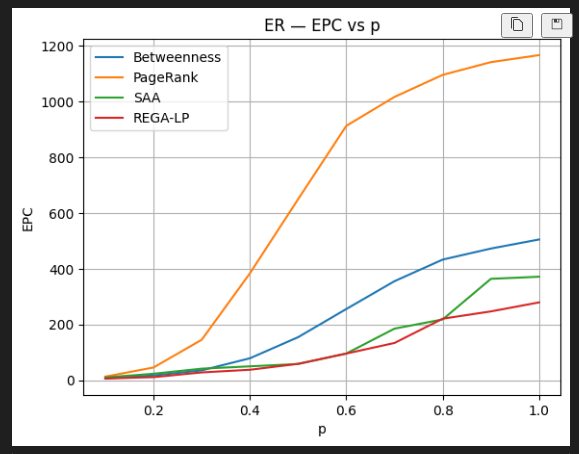

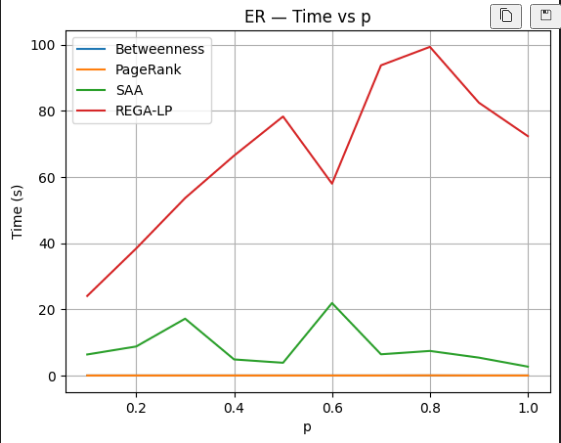

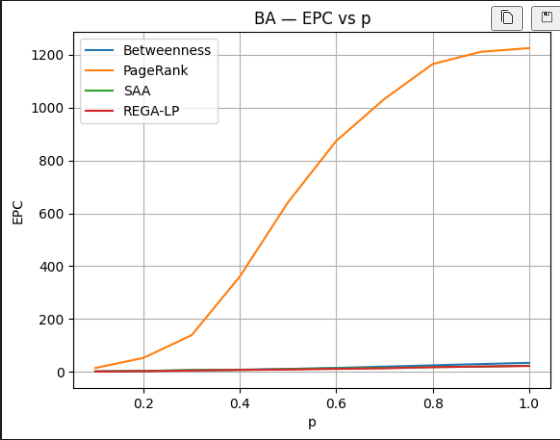

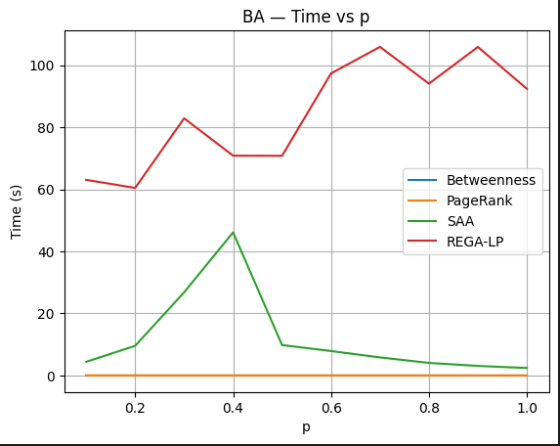

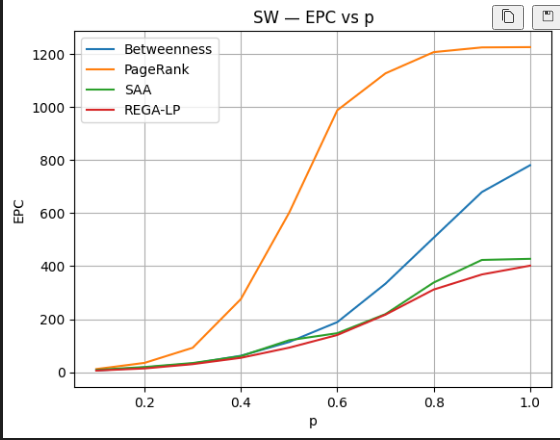

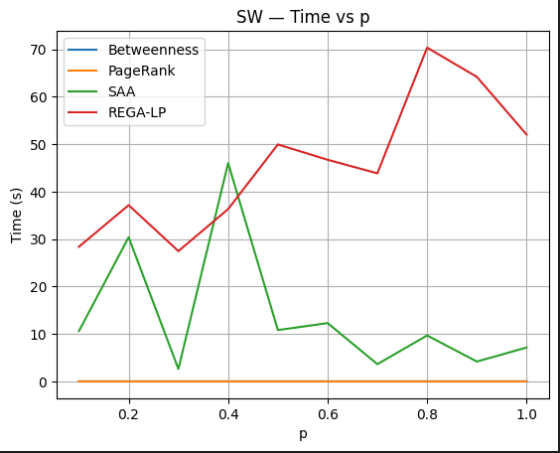